In [1]:
import torch.nn as nn
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import progressbar
import pandas as pd
import re
import unidecode
import random

## Parsing the HTML files and get the preprocessed appropriate information

In [2]:
day_after_day = []

#reading all of the HTML files from 2012-to 2019 and get every day to the dataset
for year in range (2,9):
    
    for month in range (1,13):
        path = 'weather/201'+str(year)+'_'+str(month)+'.html'
        
        html_tables = pd.read_html(path)
        day_after_day.append(html_tables[0].to_numpy())

#print(len(day_after_day))

In [3]:
data = []

#In this section we will get a rid off the unnecessary weather informations. Keep the day, month, min and max daily temp.

for months in range (len(day_after_day)):
    
    for days in range(len(day_after_day[months])):
        temp = day_after_day[months][days][0:3]
        temp[0] = re.sub(r'[a-z]+', '', unidecode.unidecode(temp[0]), re.I)
        temp[0] = temp[0].split('.')
        del temp[0][0]
        temp[0] = ''.join(temp[0])
        data.append(temp)
        
        
    
#len(data)

In [4]:
#This function will create an array with the appropriate and formatted information in it.

def data_preprocess(prev_days, sequence, data):
        
    inputs2 = []
    outputs2 = []
    
    for item in range(0, len(data)-prev_days-(sequence-1)):
        
        months = []
        min_temps = []
        max_temps = []
        
        #Get every shifted data in arrays
        for i in range(0,prev_days):
        
            months.append(data[item+i][0][0]+data[item+i][0][1])

            min_temps.append(data[item+i][1])
        
            max_temps.append(data[item+i][2])
        
        #Here we will concatenate the array into one row of input data
        row = []
        for i in range(0,prev_days):
            row.append(int(months[i]))
            row.append(float(min_temps[i]))
            row.append(float(max_temps[i]))
        inputs2.append(row)
        
        #Here we concatenate the daily values after sequence as output array.
        following_month = data[item+prev_days-1+sequence][0][0]+data[item+prev_days-1+sequence][0][1]
        following_min_temp = data[item+prev_days-1+sequence][1]
        following_max_temp = data[item+prev_days-1+sequence][2]
        
        outputs2.append([int(following_month), float(following_min_temp), float(following_max_temp)])  
    
    return (inputs2,outputs2)

## Get different type of dataset to different type of training

In [5]:
#Prepocessed data for forecasting in on day, week and month

#Separate the inputs and outputs
day_inputs, day_outputs = data_preprocess(7, 1, data)
week_inputs, week_outputs = data_preprocess(7, 7, data)
month_inputs, month_outputs = data_preprocess(7, 28, data)

day_inputs = np.array(day_inputs)
day_outputs = np.array(day_outputs)
week_inputs = np.array(week_inputs)
week_outputs = np.array(week_outputs)
month_inputs = np.array(month_inputs)
month_outputs = np.array(month_outputs)


#print(len(inputs2),len(outputs2))
print("One input sample:")
print(day_inputs[0])
print("One output sample:")
print(day_outputs[0])


One input sample:
[ 1.  3. -1.  1.  4.  0.  1.  6.  1.  1.  6.  1.  1.  4.  0.  1.  5.  0.
  1.  4. -1.]
One output sample:
[1. 4. 0.]


## Loading and normalize the dataset from saved Numpy array

In [6]:
def prepare_data_for_loader(inputs, targets):

    #Splitting the train and validation dataset
    x_train = inputs[0:2000]
    x_test = inputs[2001:2545]
    y_train = targets[0:2000]
    y_test = targets[2001:2545]

    #Normalization parameters
    means = x_train.mean()
    stds = x_train.std()
    
    
    #Noramlize TRAIN and TEST dataset
    x_train = (x_train - means) / stds
    y_train = (y_train - means) / stds
    x_test = (x_test - means) / stds
    y_test = (y_test - means) / stds

    #Transforming to numpy array
    x_train = torch.from_numpy(x_train).float()
    x_test = torch.from_numpy(x_test).float()
    y_train = torch.from_numpy(y_train).float()
    y_test = torch.from_numpy(y_test).float()
    
    return (x_train, y_train, x_test, y_test, means, stds)
    

In [7]:
#Convert train and test dataset to tensor


day_x_train, day_y_train, day_x_test, day_y_test, day_means, day_stds = prepare_data_for_loader(day_inputs, day_outputs)
week_x_train,week_y_train,week_x_test,week_y_test, week_means, week_stds = prepare_data_for_loader(week_inputs, week_outputs)
month_x_train,month_y_train,month_x_test,month_y_test, month_means, month_stds = prepare_data_for_loader(month_inputs, month_outputs)

day_train_ds = TensorDataset(day_x_train, day_y_train)
day_test_ds = TensorDataset(day_x_test, day_y_test)

week_train_ds = TensorDataset(week_x_train, week_y_train)
week_test_ds = TensorDataset(week_x_test, week_y_test)

month_train_ds = TensorDataset(month_x_train, month_y_train)
month_test_ds = TensorDataset(month_x_test, month_y_test)

#Example of the training dataset
day_train_ds[0:3]


(tensor([[-1.0272, -0.8096, -1.2449, -1.0272, -0.7008, -1.1361, -1.0272, -0.4832,
          -1.0272, -1.0272, -0.4832, -1.0272, -1.0272, -0.7008, -1.1361, -1.0272,
          -0.5920, -1.1361, -1.0272, -0.7008, -1.2449],
         [-1.0272, -0.7008, -1.1361, -1.0272, -0.4832, -1.0272, -1.0272, -0.4832,
          -1.0272, -1.0272, -0.7008, -1.1361, -1.0272, -0.5920, -1.1361, -1.0272,
          -0.7008, -1.2449, -1.0272, -0.7008, -1.1361],
         [-1.0272, -0.4832, -1.0272, -1.0272, -0.4832, -1.0272, -1.0272, -0.7008,
          -1.1361, -1.0272, -0.5920, -1.1361, -1.0272, -0.7008, -1.2449, -1.0272,
          -0.7008, -1.1361, -1.0272, -0.7008, -1.2449]]),
 tensor([[-1.0272, -0.7008, -1.1361],
         [-1.0272, -0.7008, -1.2449],
         [-1.0272, -0.8096, -1.2449]]))

In [8]:
#Save the dataset and the tensor training data

np.savetxt("day_x_train.csv", day_x_train)
np.savetxt("day_y_train.csv", day_y_train)
np.savetxt("dataset.csv", np.array(data), fmt='%s')

## Dataloader

In [9]:
day_batch_size = 16
week_batch_size = 16
month_batch_size = 16

#Make the dataloader for every models's training and evaluation

day_train_dl = DataLoader(day_train_ds, day_batch_size, shuffle=True)
day_test_dl = DataLoader(day_test_ds, day_batch_size, shuffle=True)

week_train_dl = DataLoader(week_train_ds, week_batch_size, shuffle=True)
week_test_dl = DataLoader(week_test_ds, week_batch_size, shuffle=True)

month_train_dl = DataLoader(month_train_ds, month_batch_size, shuffle=True)
month_test_dl = DataLoader(month_test_ds, month_batch_size, shuffle=True)

#Get a minibatch sample

next(iter(day_test_dl))

[tensor([[-0.2656,  2.1715,  1.1161, -0.2656,  2.0410,  1.1053, -0.2656,  1.9539,
           0.8115, -0.2656,  2.1498,  0.8115, -0.2656,  2.0083,  0.9203, -0.2656,
           2.0301,  0.8441, -0.2656,  2.2912,  0.8333],
         [-1.0272, -0.2112, -1.0381, -1.0272, -0.4180, -1.2340, -1.0272, -0.6247,
          -1.3754, -0.9184, -0.2330, -0.7226, -0.9184, -0.1895, -0.7008, -0.9184,
          -0.8749, -1.1143, -0.9184, -0.8749, -1.3428],
         [ 0.1696,  0.3545, -0.0480,  0.1696, -0.5920, -1.0381,  0.1696, -0.5376,
          -1.3319,  0.1696, -0.1895, -0.8096,  0.1696, -0.5376, -1.0381,  0.1696,
          -0.8096, -1.3863,  0.1696, -1.0708, -1.6909],
         [ 0.0608,  0.1260, -0.7879,  0.0608,  0.1043, -0.7117,  0.0608,  0.1043,
          -0.9946,  0.0608,  0.1369, -0.6029,  0.0608,  0.2457, -0.5050,  0.0608,
           0.0825, -0.8205,  0.0608, -0.0045, -0.4615],
         [ 0.0608, -0.0698, -0.3744,  0.0608, -0.2004, -0.7988,  0.0608,  0.0064,
          -0.6356,  0.0608, -0.0807, -

## Network construction

In [10]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()


class WeatherNet(nn.Module):
    #initialize the layers
    def __init__(self, prev_days, sequence):
        super().__init__()
        self.linear1 = nn.Linear(prev_days*3, prev_days*4)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(prev_days*4, prev_days*5)
        self.act2 = nn.ReLU()
        self.linear3 = nn.Linear(prev_days*5, prev_days*5)
        self.act3 = nn.ReLU()
        self.linear4 = nn.Linear(prev_days*5, prev_days*4)
        self.act4 = nn.ReLU()
        self.linear5 = nn.Linear(prev_days*4, prev_days*3)
        self.act5 = nn.ReLU()
        self.linear6 = nn.Linear(prev_days*3, 3)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.linear3(x)
        x = self.act3(x)
        x = self.linear4(x)
        x = self.act4(x)
        x = self.linear5(x)
        x = self.act5(x)
        x = self.linear6(x)
        return x

## Network creation

In [11]:
#Different forecasting style needs different model

model_next_day = WeatherNet(7,1)
model_next_week = WeatherNet(7,7)
model_next_month = WeatherNet(7,28)

In [29]:
#Defining optimizers

day_opt = torch.optim.SGD(model_next_day.parameters(), lr=0.001, momentum = 0.8, weight_decay=1e-5, nesterov=True)
week_opt = torch.optim.SGD(model_next_week.parameters(), lr=0.001, momentum = 0.8, weight_decay=1e-2, nesterov=True)
month_opt = torch.optim.SGD(model_next_month.parameters(), lr=0.001, momentum = 0.9, weight_decay=1e-2, nesterov=True)

#opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [13]:
#Defining loss functions

loss_fn = F.mse_loss

day_loss = loss_fn(model_next_day(day_x_train.float()),day_y_train.float())
week_loss = loss_fn(model_next_week(week_x_train.float()),week_y_train.float())
month_loss = loss_fn(model_next_month(month_x_train.float()),month_y_train.float())

#print(day_loss)

In [14]:
#This function will train the selected newtwork in the epoch loop

def train(epoch, network, trainloader, loss_fn, optimizer):
    running_loss = 0.0
    correct = 0.0
    total = 0
    
    #network training
    bar = progressbar.ProgressBar(0, len(trainloader), redirect_stdout=False)
    i = 0
    for x, y in trainloader:
        
        optimizer.zero_grad()
        output = network(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        
        #statistics
        running_loss += loss.item()
        
        i += 1
        bar.update(i)
        
    bar.finish()
    
    train_loss = running_loss / len(trainloader)
    
    print("Train epoch % d loss: %.5f" % (epoch+1, train_loss))
    return train_loss

In [15]:
#This function will evaluate the model in the epoch loop after training

def val(epoch, network, testloader, loss_fn):
    running_loss = 0.0
    correct = 0.0
    total = 0
    
    #network eval
    bar = progressbar.ProgressBar(0, len(testloader), redirect_stdout=False)
    i = 0
    for x, y in testloader:
        output = network(x)
        loss = loss_fn(output, y)
        
        #statistics
        running_loss += loss.item()
        i += 1
        bar.update(i)
    
    bar.finish()
    
    val_loss = running_loss / len(testloader)
    
    print("Test epoch %d loss: %.5f" % (epoch+1, val_loss))
    return val_loss

In [16]:
def training(num_epochs, model, loss_fn, opt, train_loader, test_loader):
    trLoss = []
    valLoss = []
    x = range(num_epochs)
    
    for epoch in range(num_epochs):
        tr_loss = train(epoch, model, train_loader, loss_fn, opt)
        val_loss = val(epoch, model, test_loader, loss_fn)
        
        trLoss.append(tr_loss)
        valLoss.append(val_loss)
        
    plt.figure()
    plt.plot(x,trLoss, 'b-', label='training_loss')
    plt.plot(x,valLoss, 'y-', label='validation_loss')
    plt.show
    print("Training is done!")

## Training of the 3 kinds of model

100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  1 loss: 0.84586


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 1 loss: 0.78289


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  2 loss: 0.74878


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 2 loss: 0.76069


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  3 loss: 0.72337


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 3 loss: 0.75638


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  4 loss: 0.71197


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 4 loss: 0.74875


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  5 loss: 0.69941


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 5 loss: 0.73498


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  6 loss: 0.68070


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 6 loss: 0.71083


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  7 loss: 0.64860


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 7 loss: 0.66546


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  8 loss: 0.58824


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 8 loss: 0.57519


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  9 loss: 0.47347


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 9 loss: 0.41689


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  10 loss: 0.30974


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 10 loss: 0.24235


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  11 loss: 0.19310


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 11 loss: 0.17152


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  12 loss: 0.15587


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 12 loss: 0.15615


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  13 loss: 0.14213


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 13 loss: 0.14927


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  14 loss: 0.13345


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 14 loss: 0.14574


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  15 loss: 0.12675


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 15 loss: 0.14089


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  16 loss: 0.12160


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 16 loss: 0.13842


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  17 loss: 0.11803


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 17 loss: 0.13663


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  18 loss: 0.11509


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 18 loss: 0.13515


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  19 loss: 0.11317


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 19 loss: 0.13420


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  20 loss: 0.11139


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 20 loss: 0.13183


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  21 loss: 0.10996


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 21 loss: 0.13089


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  22 loss: 0.10865


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 22 loss: 0.12916


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  23 loss: 0.10781


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 23 loss: 0.12949


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  24 loss: 0.10686


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 24 loss: 0.12837


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  25 loss: 0.10610


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 25 loss: 0.12703


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  26 loss: 0.10532


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 26 loss: 0.12600


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  27 loss: 0.10460


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 27 loss: 0.12563


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  28 loss: 0.10391


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 28 loss: 0.12591


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  29 loss: 0.10338


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 29 loss: 0.12440


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  30 loss: 0.10282


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 30 loss: 0.12442


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  31 loss: 0.10222


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 31 loss: 0.12277


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  32 loss: 0.10156


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 32 loss: 0.12374


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  33 loss: 0.10108


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 33 loss: 0.12253


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  34 loss: 0.10080


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 34 loss: 0.12104


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  35 loss: 0.10018


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 35 loss: 0.12053


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  36 loss: 0.09986


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 36 loss: 0.11942


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  37 loss: 0.09947


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 37 loss: 0.11864


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  38 loss: 0.09887


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 38 loss: 0.11854


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  39 loss: 0.09841


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 39 loss: 0.11834


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  40 loss: 0.09831


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 40 loss: 0.11720


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  41 loss: 0.09771


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 41 loss: 0.11610


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  42 loss: 0.09732


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 42 loss: 0.11612


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  43 loss: 0.09703


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 43 loss: 0.11582


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  44 loss: 0.09652


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 44 loss: 0.11565


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  45 loss: 0.09603


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 45 loss: 0.11504


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  46 loss: 0.09581


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 46 loss: 0.11434


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  47 loss: 0.09576


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 47 loss: 0.11323


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  48 loss: 0.09514


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 48 loss: 0.11527


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  49 loss: 0.09502


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 49 loss: 0.11339


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  50 loss: 0.09461


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 50 loss: 0.11217


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  51 loss: 0.09445


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 51 loss: 0.11265


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  52 loss: 0.09425


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 52 loss: 0.11267


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  53 loss: 0.09374


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 53 loss: 0.11220


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  54 loss: 0.09347


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 54 loss: 0.11186


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  55 loss: 0.09326


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 55 loss: 0.11079


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  56 loss: 0.09292


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 56 loss: 0.11121


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  57 loss: 0.09250


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 57 loss: 0.11167


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  58 loss: 0.09226


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 58 loss: 0.11174


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  59 loss: 0.09201


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 59 loss: 0.11075


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  60 loss: 0.09177


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 60 loss: 0.11011


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  61 loss: 0.09140


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 61 loss: 0.10942


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  62 loss: 0.09117


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 62 loss: 0.10935


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  63 loss: 0.09085


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 63 loss: 0.10896


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  64 loss: 0.09039


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 64 loss: 0.10874


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  65 loss: 0.09016


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 65 loss: 0.10914


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  66 loss: 0.08978


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 66 loss: 0.10800


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  67 loss: 0.08944


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 67 loss: 0.10771


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  68 loss: 0.08891


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 68 loss: 0.10758


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  69 loss: 0.08848


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 69 loss: 0.10634


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  70 loss: 0.08819


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 70 loss: 0.10654


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  71 loss: 0.08754


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 71 loss: 0.10718


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  72 loss: 0.08722


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 72 loss: 0.10635


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  73 loss: 0.08670


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 73 loss: 0.10475


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  74 loss: 0.08617


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 74 loss: 0.10511


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  75 loss: 0.08562


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 75 loss: 0.10332


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  76 loss: 0.08497


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 76 loss: 0.10326


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  77 loss: 0.08426


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 77 loss: 0.10205


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  78 loss: 0.08362


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 78 loss: 0.10146


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  79 loss: 0.08280


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 79 loss: 0.10092


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  80 loss: 0.08166


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 80 loss: 0.09979


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  81 loss: 0.08065


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 81 loss: 0.09788


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  82 loss: 0.07955


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 82 loss: 0.09760


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  83 loss: 0.07843


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 83 loss: 0.09676


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  84 loss: 0.07726


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 84 loss: 0.09460


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  85 loss: 0.07598


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 85 loss: 0.09316


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  86 loss: 0.07471


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 86 loss: 0.09221


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  87 loss: 0.07328


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 87 loss: 0.09139


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  88 loss: 0.07199


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 88 loss: 0.08938


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  89 loss: 0.07038


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 89 loss: 0.08692


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  90 loss: 0.06903


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 90 loss: 0.08429


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  91 loss: 0.06742


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 91 loss: 0.08399


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  92 loss: 0.06630


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 92 loss: 0.08140


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  93 loss: 0.06464


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 93 loss: 0.08011


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  94 loss: 0.06291


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 94 loss: 0.07891


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  95 loss: 0.06178


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 95 loss: 0.07632


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  96 loss: 0.06063


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 96 loss: 0.07502


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  97 loss: 0.05932


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 97 loss: 0.07379


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  98 loss: 0.05841


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 98 loss: 0.07224


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  99 loss: 0.05739


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 99 loss: 0.07135


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  100 loss: 0.05668


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 100 loss: 0.07070


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  101 loss: 0.05610


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 101 loss: 0.06956


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  102 loss: 0.05544


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 102 loss: 0.06876


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  103 loss: 0.05487


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 103 loss: 0.06811


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  104 loss: 0.05449


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 104 loss: 0.06823


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  105 loss: 0.05421


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 105 loss: 0.06783


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  106 loss: 0.05400


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 106 loss: 0.06692


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  107 loss: 0.05366


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 107 loss: 0.06644


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  108 loss: 0.05340


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 108 loss: 0.06726


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  109 loss: 0.05333


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 109 loss: 0.06597


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  110 loss: 0.05280


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 110 loss: 0.06829


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  111 loss: 0.05326


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 111 loss: 0.06603


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  112 loss: 0.05272


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 112 loss: 0.06579


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  113 loss: 0.05271


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 113 loss: 0.06513


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  114 loss: 0.05262


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 114 loss: 0.06548


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  115 loss: 0.05236


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 115 loss: 0.06540


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  116 loss: 0.05240


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 116 loss: 0.06492


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  117 loss: 0.05212


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 117 loss: 0.06514


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  118 loss: 0.05236


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 118 loss: 0.06494


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  119 loss: 0.05218


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 119 loss: 0.06508


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  120 loss: 0.05217


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 120 loss: 0.06462


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  121 loss: 0.05212


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 121 loss: 0.06498


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  122 loss: 0.05206


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 122 loss: 0.06631


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  123 loss: 0.05217


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 123 loss: 0.06479


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  124 loss: 0.05202


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 124 loss: 0.06452


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  125 loss: 0.05174


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 125 loss: 0.06461


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  126 loss: 0.05188


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 126 loss: 0.06473


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  127 loss: 0.05177


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 127 loss: 0.06560


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  128 loss: 0.05188


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 128 loss: 0.06461


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  129 loss: 0.05168


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 129 loss: 0.06438


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  130 loss: 0.05164


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 130 loss: 0.06447


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  131 loss: 0.05168


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 131 loss: 0.06459


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  132 loss: 0.05147


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 132 loss: 0.06437


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  133 loss: 0.05153


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 133 loss: 0.06419


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  134 loss: 0.05160


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 134 loss: 0.06418


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  135 loss: 0.05158


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 135 loss: 0.06402


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  136 loss: 0.05141


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 136 loss: 0.06372


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  137 loss: 0.05142


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 137 loss: 0.06428


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  138 loss: 0.05136


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 138 loss: 0.06385


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  139 loss: 0.05126


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 139 loss: 0.06419


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  140 loss: 0.05119


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 140 loss: 0.06410


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  141 loss: 0.05126


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 141 loss: 0.06452


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  142 loss: 0.05131


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 142 loss: 0.06389


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  143 loss: 0.05123


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 143 loss: 0.06399


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  144 loss: 0.05119


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 144 loss: 0.06398


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  145 loss: 0.05110


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 145 loss: 0.06416


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  146 loss: 0.05125


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 146 loss: 0.06437


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  147 loss: 0.05124


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 147 loss: 0.06369


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  148 loss: 0.05115


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 148 loss: 0.06354


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  149 loss: 0.05105


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 149 loss: 0.06405


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  150 loss: 0.05099


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 150 loss: 0.06399


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  151 loss: 0.05103


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 151 loss: 0.06389


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  152 loss: 0.05100


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 152 loss: 0.06397


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  153 loss: 0.05078


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 153 loss: 0.06382


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  154 loss: 0.05097


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 154 loss: 0.06357


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  155 loss: 0.05091


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 155 loss: 0.06371


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  156 loss: 0.05081


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 156 loss: 0.06353


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  157 loss: 0.05064


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 157 loss: 0.06396


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  158 loss: 0.05088


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 158 loss: 0.06368


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  159 loss: 0.05075


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 159 loss: 0.06378


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  160 loss: 0.05088


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 160 loss: 0.06417


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  161 loss: 0.05072


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 161 loss: 0.06353


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  162 loss: 0.05082


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 162 loss: 0.06376


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  163 loss: 0.05063


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 163 loss: 0.06363


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  164 loss: 0.05068


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 164 loss: 0.06313


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  165 loss: 0.05069


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 165 loss: 0.06355


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  166 loss: 0.05058


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 166 loss: 0.06386


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  167 loss: 0.05053


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 167 loss: 0.06335


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  168 loss: 0.05048


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 168 loss: 0.06379


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  169 loss: 0.05070


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 169 loss: 0.06366


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  170 loss: 0.05055


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 170 loss: 0.06356


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  171 loss: 0.05054


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 171 loss: 0.06342


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  172 loss: 0.05047


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 172 loss: 0.06327


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  173 loss: 0.05037


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 173 loss: 0.06403


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  174 loss: 0.05048


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 174 loss: 0.06314


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  175 loss: 0.05036


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 175 loss: 0.06333


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  176 loss: 0.05039


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 176 loss: 0.06324


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  177 loss: 0.05043


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 177 loss: 0.06324


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  178 loss: 0.05030


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 178 loss: 0.06332


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  179 loss: 0.05028


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 179 loss: 0.06342


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  180 loss: 0.05015


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 180 loss: 0.06357


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  181 loss: 0.05029


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 181 loss: 0.06315


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  182 loss: 0.05024


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 182 loss: 0.06324


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  183 loss: 0.05032


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 183 loss: 0.06338


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  184 loss: 0.05013


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 184 loss: 0.06316


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  185 loss: 0.05030


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 185 loss: 0.06374


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  186 loss: 0.05020


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 186 loss: 0.06335


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  187 loss: 0.05003


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 187 loss: 0.06332


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  188 loss: 0.04994


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 188 loss: 0.06391


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  189 loss: 0.05013


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 189 loss: 0.06312


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  190 loss: 0.04994


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 190 loss: 0.06298


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  191 loss: 0.05027


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 191 loss: 0.06330


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  192 loss: 0.05012


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 192 loss: 0.06333


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  193 loss: 0.04997


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 193 loss: 0.06320


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  194 loss: 0.04990


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 194 loss: 0.06313


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  195 loss: 0.05002


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 195 loss: 0.06321


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  196 loss: 0.04976


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 196 loss: 0.06321


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  197 loss: 0.04990


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 197 loss: 0.06337


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  198 loss: 0.04986


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 198 loss: 0.06288


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  199 loss: 0.04987


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 199 loss: 0.06347


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  200 loss: 0.05007


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 200 loss: 0.06324


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  201 loss: 0.04976


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 201 loss: 0.06299


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  202 loss: 0.04989


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 202 loss: 0.06287


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  203 loss: 0.04979


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 203 loss: 0.06360


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  204 loss: 0.04984


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 204 loss: 0.06285


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  205 loss: 0.04986


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 205 loss: 0.06301


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  206 loss: 0.04974


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 206 loss: 0.06313


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  207 loss: 0.04980


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 207 loss: 0.06308


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  208 loss: 0.04978


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 208 loss: 0.06318


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  209 loss: 0.04968


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 209 loss: 0.06318


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  210 loss: 0.04969


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 210 loss: 0.06283


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  211 loss: 0.04964


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 211 loss: 0.06290


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  212 loss: 0.04955


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 212 loss: 0.06284


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  213 loss: 0.04960


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 213 loss: 0.06306


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  214 loss: 0.04953


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 214 loss: 0.06302


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  215 loss: 0.04968


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 215 loss: 0.06293


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  216 loss: 0.04947


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 216 loss: 0.06334


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  217 loss: 0.04942


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 217 loss: 0.06307


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  218 loss: 0.04942


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 218 loss: 0.06279


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  219 loss: 0.04938


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 219 loss: 0.06302


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  220 loss: 0.04939


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 220 loss: 0.06299


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  221 loss: 0.04912


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 221 loss: 0.06350


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  222 loss: 0.04943


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 222 loss: 0.06288


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  223 loss: 0.04938


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 223 loss: 0.06368


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  224 loss: 0.04925


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 224 loss: 0.06278


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  225 loss: 0.04955


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 225 loss: 0.06295


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  226 loss: 0.04964


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 226 loss: 0.06271


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  227 loss: 0.04939


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 227 loss: 0.06286


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  228 loss: 0.04929


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 228 loss: 0.06323


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  229 loss: 0.04926


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 229 loss: 0.06294


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  230 loss: 0.04922


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 230 loss: 0.06319


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  231 loss: 0.04931


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 231 loss: 0.06303


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  232 loss: 0.04939


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 232 loss: 0.06246


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  233 loss: 0.04922


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 233 loss: 0.06263


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  234 loss: 0.04914


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 234 loss: 0.06281


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  235 loss: 0.04920


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 235 loss: 0.06276


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  236 loss: 0.04923


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 236 loss: 0.06312


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  237 loss: 0.04900


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 237 loss: 0.06321


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  238 loss: 0.04905


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 238 loss: 0.06308


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  239 loss: 0.04920


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 239 loss: 0.06378


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  240 loss: 0.04886


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 240 loss: 0.06332


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  241 loss: 0.04909


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 241 loss: 0.06355


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  242 loss: 0.04901


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 242 loss: 0.06267


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  243 loss: 0.04901


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 243 loss: 0.06298


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  244 loss: 0.04892


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 244 loss: 0.06330


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  245 loss: 0.04890


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 245 loss: 0.06331


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  246 loss: 0.04889


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 246 loss: 0.06302


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  247 loss: 0.04906


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 247 loss: 0.06312


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  248 loss: 0.04898


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 248 loss: 0.06278


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  249 loss: 0.04921


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 249 loss: 0.06263


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  250 loss: 0.04883


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 250 loss: 0.06289


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  251 loss: 0.04891


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 251 loss: 0.06292


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  252 loss: 0.04886


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 252 loss: 0.06278


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  253 loss: 0.04879


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 253 loss: 0.06255


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  254 loss: 0.04893


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 254 loss: 0.06271


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  255 loss: 0.04889


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 255 loss: 0.06317


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  256 loss: 0.04900


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 256 loss: 0.06311


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  257 loss: 0.04874


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 257 loss: 0.06292


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  258 loss: 0.04864


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 258 loss: 0.06331


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  259 loss: 0.04886


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 259 loss: 0.06298


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  260 loss: 0.04891


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 260 loss: 0.06319


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  261 loss: 0.04869


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 261 loss: 0.06266


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  262 loss: 0.04875


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 262 loss: 0.06224


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  263 loss: 0.04871


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 263 loss: 0.06263


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  264 loss: 0.04869


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 264 loss: 0.06308


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  265 loss: 0.04871


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 265 loss: 0.06291


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  266 loss: 0.04829


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 266 loss: 0.06259


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  267 loss: 0.04861


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 267 loss: 0.06249


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  268 loss: 0.04842


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 268 loss: 0.06259


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  269 loss: 0.04882


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 269 loss: 0.06265


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  270 loss: 0.04869


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 270 loss: 0.06254


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  271 loss: 0.04866


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 271 loss: 0.06218


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  272 loss: 0.04857


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 272 loss: 0.06245


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  273 loss: 0.04858


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 273 loss: 0.06285


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  274 loss: 0.04871


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 274 loss: 0.06236


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  275 loss: 0.04856


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 275 loss: 0.06268


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  276 loss: 0.04847


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 276 loss: 0.06225


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  277 loss: 0.04853


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 277 loss: 0.06486


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  278 loss: 0.04851


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 278 loss: 0.06281


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  279 loss: 0.04855


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 279 loss: 0.06234


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  280 loss: 0.04822


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 280 loss: 0.06214


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  281 loss: 0.04837


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 281 loss: 0.06295


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  282 loss: 0.04847


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 282 loss: 0.06306


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  283 loss: 0.04846


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 283 loss: 0.06255


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  284 loss: 0.04843


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 284 loss: 0.06224


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  285 loss: 0.04826


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 285 loss: 0.06238


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  286 loss: 0.04824


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 286 loss: 0.06260


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  287 loss: 0.04814


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 287 loss: 0.06232


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  288 loss: 0.04852


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 288 loss: 0.06244


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  289 loss: 0.04836


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 289 loss: 0.06230


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  290 loss: 0.04835


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 290 loss: 0.06238


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  291 loss: 0.04813


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 291 loss: 0.06352


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  292 loss: 0.04823


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 292 loss: 0.06223


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  293 loss: 0.04814


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 293 loss: 0.06317


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  294 loss: 0.04826


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 294 loss: 0.06336


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  295 loss: 0.04818


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 295 loss: 0.06215


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  296 loss: 0.04839


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 296 loss: 0.06334


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  297 loss: 0.04813


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 297 loss: 0.06243


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  298 loss: 0.04814


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 298 loss: 0.06251


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  299 loss: 0.04837


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 299 loss: 0.06265


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  300 loss: 0.04829


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 300 loss: 0.06242


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  301 loss: 0.04820


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 301 loss: 0.06256


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  302 loss: 0.04824


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 302 loss: 0.06303


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  303 loss: 0.04844


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 303 loss: 0.06316


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  304 loss: 0.04794


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 304 loss: 0.06262


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  305 loss: 0.04806


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 305 loss: 0.06378


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  306 loss: 0.04804


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 306 loss: 0.06255


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  307 loss: 0.04785


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 307 loss: 0.06260


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  308 loss: 0.04803


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 308 loss: 0.06301


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  309 loss: 0.04801


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 309 loss: 0.06352


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  310 loss: 0.04790


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 310 loss: 0.06212


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  311 loss: 0.04816


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 311 loss: 0.06232


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  312 loss: 0.04809


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 312 loss: 0.06345


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  313 loss: 0.04799


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 313 loss: 0.06218


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  314 loss: 0.04805


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 314 loss: 0.06297


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  315 loss: 0.04801


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 315 loss: 0.06255


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  316 loss: 0.04799


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 316 loss: 0.06314


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  317 loss: 0.04793


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 317 loss: 0.06218


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  318 loss: 0.04805


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 318 loss: 0.06255


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  319 loss: 0.04778


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 319 loss: 0.06428


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  320 loss: 0.04794


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 320 loss: 0.06225


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  321 loss: 0.04785


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 321 loss: 0.06313


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  322 loss: 0.04787


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 322 loss: 0.06194


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  323 loss: 0.04798


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 323 loss: 0.06210


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  324 loss: 0.04772


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 324 loss: 0.06308


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  325 loss: 0.04786


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 325 loss: 0.06321


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  326 loss: 0.04769


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 326 loss: 0.06216


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  327 loss: 0.04790


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 327 loss: 0.06193


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  328 loss: 0.04770


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 328 loss: 0.06285


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  329 loss: 0.04794


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 329 loss: 0.06231


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  330 loss: 0.04797


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 330 loss: 0.06226


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  331 loss: 0.04766


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 331 loss: 0.06230


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  332 loss: 0.04788


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 332 loss: 0.06216


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  333 loss: 0.04778


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 333 loss: 0.06252


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  334 loss: 0.04769


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 334 loss: 0.06313


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  335 loss: 0.04776


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 335 loss: 0.06357


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  336 loss: 0.04780


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 336 loss: 0.06308


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  337 loss: 0.04795


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 337 loss: 0.06328


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  338 loss: 0.04776


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 338 loss: 0.06187


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  339 loss: 0.04761


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 339 loss: 0.06206


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  340 loss: 0.04762


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 340 loss: 0.06364


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  341 loss: 0.04773


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 341 loss: 0.06260


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  342 loss: 0.04768


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 342 loss: 0.06182


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  343 loss: 0.04756


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 343 loss: 0.06183


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  344 loss: 0.04752


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 344 loss: 0.06361


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  345 loss: 0.04763


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 345 loss: 0.06394


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  346 loss: 0.04746


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 346 loss: 0.06305


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  347 loss: 0.04759


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 347 loss: 0.06479


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  348 loss: 0.04766


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 348 loss: 0.06209


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  349 loss: 0.04772


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 349 loss: 0.06264


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  350 loss: 0.04740


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 350 loss: 0.06253


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  351 loss: 0.04750


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 351 loss: 0.06208


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  352 loss: 0.04749


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 352 loss: 0.06294


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  353 loss: 0.04733


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 353 loss: 0.06260


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  354 loss: 0.04768


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 354 loss: 0.06207


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  355 loss: 0.04753


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 355 loss: 0.06255


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  356 loss: 0.04738


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 356 loss: 0.06221


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  357 loss: 0.04744


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 357 loss: 0.06208


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  358 loss: 0.04735


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 358 loss: 0.06202


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  359 loss: 0.04743


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 359 loss: 0.06209


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  360 loss: 0.04737


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 360 loss: 0.06236


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  361 loss: 0.04725


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 361 loss: 0.06366


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  362 loss: 0.04734


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 362 loss: 0.06276


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  363 loss: 0.04723


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 363 loss: 0.06249


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  364 loss: 0.04732


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 364 loss: 0.06175


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  365 loss: 0.04733


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 365 loss: 0.06243


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  366 loss: 0.04727


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 366 loss: 0.06193


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  367 loss: 0.04748


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 367 loss: 0.06200


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  368 loss: 0.04723


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 368 loss: 0.06280


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  369 loss: 0.04729


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 369 loss: 0.06210


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  370 loss: 0.04728


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 370 loss: 0.06269


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  371 loss: 0.04737


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 371 loss: 0.06253


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  372 loss: 0.04736


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 372 loss: 0.06212


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  373 loss: 0.04691


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 373 loss: 0.06158


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  374 loss: 0.04718


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 374 loss: 0.06256


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  375 loss: 0.04728


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 375 loss: 0.06181


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  376 loss: 0.04719


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 376 loss: 0.06278


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  377 loss: 0.04724


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 377 loss: 0.06212


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  378 loss: 0.04710


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 378 loss: 0.06237


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  379 loss: 0.04721


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 379 loss: 0.06239


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  380 loss: 0.04716


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 380 loss: 0.06178


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  381 loss: 0.04715


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 381 loss: 0.06195


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  382 loss: 0.04736


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 382 loss: 0.06427


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  383 loss: 0.04706


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 383 loss: 0.06251


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  384 loss: 0.04713


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 384 loss: 0.06264


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  385 loss: 0.04724


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 385 loss: 0.06331


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  386 loss: 0.04709


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 386 loss: 0.06198


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  387 loss: 0.04706


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 387 loss: 0.06214


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  388 loss: 0.04706


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 388 loss: 0.06188


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  389 loss: 0.04704


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 389 loss: 0.06288


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  390 loss: 0.04707


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 390 loss: 0.06177


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  391 loss: 0.04711


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 391 loss: 0.06361


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  392 loss: 0.04700


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 392 loss: 0.06147


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  393 loss: 0.04699


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 393 loss: 0.06209


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  394 loss: 0.04700


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 394 loss: 0.06202


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  395 loss: 0.04683


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 395 loss: 0.06207


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  396 loss: 0.04693


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 396 loss: 0.06284


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  397 loss: 0.04693


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 397 loss: 0.06181


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  398 loss: 0.04694


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 398 loss: 0.06170


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  399 loss: 0.04698


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 399 loss: 0.06192


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  400 loss: 0.04695


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 400 loss: 0.06207
Training is done!


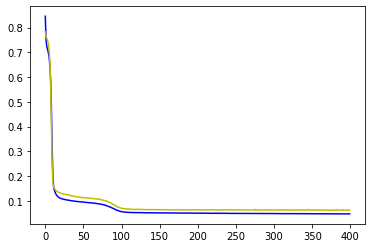

In [17]:
#1. Train this model, to predict temp after one day

model_next_day.apply(weight_reset)
training(400, model_next_day, loss_fn, day_opt, day_train_dl, day_test_dl)

100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  1 loss: 0.94373


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 1 loss: 0.81798


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  2 loss: 0.79431


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 2 loss: 0.76524


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  3 loss: 0.74323


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 3 loss: 0.75143


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  4 loss: 0.72174


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 4 loss: 0.74430


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  5 loss: 0.70747


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 5 loss: 0.73242


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  6 loss: 0.68822


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 6 loss: 0.71267


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  7 loss: 0.64855


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 7 loss: 0.65853


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  8 loss: 0.55291


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 8 loss: 0.52891


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  9 loss: 0.42124


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 9 loss: 0.41101


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  10 loss: 0.33651


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 10 loss: 0.33586


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  11 loss: 0.29065


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 11 loss: 0.29505


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  12 loss: 0.26668


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 12 loss: 0.27327


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  13 loss: 0.25131


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 13 loss: 0.25304


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  14 loss: 0.24052


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 14 loss: 0.24178


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  15 loss: 0.23175


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 15 loss: 0.23300


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  16 loss: 0.22520


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 16 loss: 0.22679


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  17 loss: 0.22006


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 17 loss: 0.22125


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  18 loss: 0.21597


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 18 loss: 0.21830


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  19 loss: 0.21232


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 19 loss: 0.21540


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  20 loss: 0.20994


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 20 loss: 0.21224


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  21 loss: 0.20765


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 21 loss: 0.21088


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  22 loss: 0.20628


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 22 loss: 0.21008


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  23 loss: 0.20456


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 23 loss: 0.20691


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  24 loss: 0.20328


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 24 loss: 0.20685


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  25 loss: 0.20211


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 25 loss: 0.20700


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  26 loss: 0.20165


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 26 loss: 0.20499


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  27 loss: 0.20071


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 27 loss: 0.20663


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  28 loss: 0.19981


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 28 loss: 0.20589


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  29 loss: 0.19943


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 29 loss: 0.20431


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  30 loss: 0.19837


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 30 loss: 0.20498


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  31 loss: 0.19848


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 31 loss: 0.20406


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  32 loss: 0.19805


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 32 loss: 0.20493


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  33 loss: 0.19764


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 33 loss: 0.20519


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  34 loss: 0.19733


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 34 loss: 0.20250


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  35 loss: 0.19650


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 35 loss: 0.20272


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  36 loss: 0.19662


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 36 loss: 0.20368


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  37 loss: 0.19600


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 37 loss: 0.20544


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  38 loss: 0.19607


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 38 loss: 0.20291


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  39 loss: 0.19563


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 39 loss: 0.20199


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  40 loss: 0.19509


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 40 loss: 0.20304


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  41 loss: 0.19506


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 41 loss: 0.20276


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  42 loss: 0.19489


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 42 loss: 0.20418


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  43 loss: 0.19445


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 43 loss: 0.20416


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  44 loss: 0.19444


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 44 loss: 0.20446


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  45 loss: 0.19436


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 45 loss: 0.20201


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  46 loss: 0.19422


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 46 loss: 0.20251


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  47 loss: 0.19381


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 47 loss: 0.20362


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  48 loss: 0.19389


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 48 loss: 0.20400


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  49 loss: 0.19344


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 49 loss: 0.20367


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  50 loss: 0.19351


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 50 loss: 0.20301


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  51 loss: 0.19326


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 51 loss: 0.20268


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  52 loss: 0.19318


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 52 loss: 0.20274


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  53 loss: 0.19296


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 53 loss: 0.20425


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  54 loss: 0.19280


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 54 loss: 0.20171


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  55 loss: 0.19284


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 55 loss: 0.20256


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  56 loss: 0.19270


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 56 loss: 0.20274


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  57 loss: 0.19235


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 57 loss: 0.20292


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  58 loss: 0.19213


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 58 loss: 0.20439


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  59 loss: 0.19234


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 59 loss: 0.20283


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  60 loss: 0.19196


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 60 loss: 0.20386


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  61 loss: 0.19185


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 61 loss: 0.20430


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  62 loss: 0.19198


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 62 loss: 0.20295


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  63 loss: 0.19161


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 63 loss: 0.20237


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  64 loss: 0.19160


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 64 loss: 0.20532


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  65 loss: 0.19137


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 65 loss: 0.20197


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  66 loss: 0.19084


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 66 loss: 0.20397


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  67 loss: 0.19110


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 67 loss: 0.20218


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  68 loss: 0.19101


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 68 loss: 0.20316


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  69 loss: 0.19075


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 69 loss: 0.20224


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  70 loss: 0.19060


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 70 loss: 0.20309


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  71 loss: 0.19032


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 71 loss: 0.20210


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  72 loss: 0.19043


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 72 loss: 0.20360


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  73 loss: 0.19022


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 73 loss: 0.20391


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  74 loss: 0.18984


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 74 loss: 0.20207


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  75 loss: 0.19005


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 75 loss: 0.20443


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  76 loss: 0.18983


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 76 loss: 0.20332


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  77 loss: 0.18963


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 77 loss: 0.20287


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  78 loss: 0.18960


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 78 loss: 0.20138


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  79 loss: 0.18975


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 79 loss: 0.20235


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  80 loss: 0.18881


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 80 loss: 0.20160


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  81 loss: 0.18890


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 81 loss: 0.20205


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  82 loss: 0.18903


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 82 loss: 0.20247


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  83 loss: 0.18872


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 83 loss: 0.20186


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  84 loss: 0.18829


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 84 loss: 0.20096


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  85 loss: 0.18812


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 85 loss: 0.20340


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  86 loss: 0.18815


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 86 loss: 0.20270


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  87 loss: 0.18772


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 87 loss: 0.20445


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  88 loss: 0.18794


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 88 loss: 0.20176


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  89 loss: 0.18777


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 89 loss: 0.20219


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  90 loss: 0.18779


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 90 loss: 0.20171


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  91 loss: 0.18725


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 91 loss: 0.20235


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  92 loss: 0.18697


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 92 loss: 0.20289


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  93 loss: 0.18689


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 93 loss: 0.20039


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  94 loss: 0.18658


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 94 loss: 0.20107


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  95 loss: 0.18610


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 95 loss: 0.20156


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  96 loss: 0.18583


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 96 loss: 0.20074


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  97 loss: 0.18589


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 97 loss: 0.19978


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  98 loss: 0.18551


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 98 loss: 0.20013


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  99 loss: 0.18570


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 99 loss: 0.20144


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  100 loss: 0.18519


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 100 loss: 0.20273


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  101 loss: 0.18507


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 101 loss: 0.19975


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  102 loss: 0.18476


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 102 loss: 0.19973


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  103 loss: 0.18431


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 103 loss: 0.20101


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  104 loss: 0.18402


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 104 loss: 0.20122


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  105 loss: 0.18389


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 105 loss: 0.20011


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  106 loss: 0.18388


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 106 loss: 0.19945


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  107 loss: 0.18325


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 107 loss: 0.19878


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  108 loss: 0.18280


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 108 loss: 0.19910


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  109 loss: 0.18234


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 109 loss: 0.19704


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  110 loss: 0.18222


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 110 loss: 0.19901


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  111 loss: 0.18187


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 111 loss: 0.20021


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  112 loss: 0.18162


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 112 loss: 0.19711


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  113 loss: 0.18113


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 113 loss: 0.19693


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  114 loss: 0.18089


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 114 loss: 0.19741


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  115 loss: 0.18042


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 115 loss: 0.19690


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  116 loss: 0.17963


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 116 loss: 0.19619


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  117 loss: 0.17953


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 117 loss: 0.19503


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  118 loss: 0.17874


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 118 loss: 0.19658


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  119 loss: 0.17853


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 119 loss: 0.19491


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  120 loss: 0.17811


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 120 loss: 0.19408


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  121 loss: 0.17738


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 121 loss: 0.19381


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  122 loss: 0.17678


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 122 loss: 0.19332


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  123 loss: 0.17637


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 123 loss: 0.19279


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  124 loss: 0.17590


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 124 loss: 0.19275


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  125 loss: 0.17525


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 125 loss: 0.19226


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  126 loss: 0.17472


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 126 loss: 0.19108


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  127 loss: 0.17417


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 127 loss: 0.19145


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  128 loss: 0.17351


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 128 loss: 0.19086


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  129 loss: 0.17274


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 129 loss: 0.18825


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  130 loss: 0.17228


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 130 loss: 0.19124


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  131 loss: 0.17167


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 131 loss: 0.18790


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  132 loss: 0.17136


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 132 loss: 0.18753


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  133 loss: 0.17054


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 133 loss: 0.18750


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  134 loss: 0.16942


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 134 loss: 0.18824


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  135 loss: 0.16922


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 135 loss: 0.18602


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  136 loss: 0.16817


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 136 loss: 0.18450


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  137 loss: 0.16820


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 137 loss: 0.18422


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  138 loss: 0.16719


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 138 loss: 0.18329


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  139 loss: 0.16721


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 139 loss: 0.18250


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  140 loss: 0.16618


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 140 loss: 0.18207


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  141 loss: 0.16550


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 141 loss: 0.18156


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  142 loss: 0.16481


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 142 loss: 0.18180


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  143 loss: 0.16431


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 143 loss: 0.18010


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  144 loss: 0.16371


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 144 loss: 0.17895


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  145 loss: 0.16383


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 145 loss: 0.17978


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  146 loss: 0.16282


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 146 loss: 0.18278


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  147 loss: 0.16256


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 147 loss: 0.17847


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  148 loss: 0.16217


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 148 loss: 0.17800


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  149 loss: 0.16147


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 149 loss: 0.17629


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  150 loss: 0.16176


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 150 loss: 0.17542


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  151 loss: 0.16108


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 151 loss: 0.17644


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  152 loss: 0.16080


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 152 loss: 0.17474


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  153 loss: 0.15951


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 153 loss: 0.17537


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  154 loss: 0.16002


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 154 loss: 0.17410


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  155 loss: 0.15936


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 155 loss: 0.17532


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  156 loss: 0.15936


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 156 loss: 0.17350


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  157 loss: 0.15926


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 157 loss: 0.17421


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  158 loss: 0.15933


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 158 loss: 0.17339


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  159 loss: 0.15864


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 159 loss: 0.17274


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  160 loss: 0.15866


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 160 loss: 0.17275


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  161 loss: 0.15850


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 161 loss: 0.17343


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  162 loss: 0.15815


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 162 loss: 0.17198


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  163 loss: 0.15807


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 163 loss: 0.17149


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  164 loss: 0.15795


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 164 loss: 0.17236


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  165 loss: 0.15764


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 165 loss: 0.17149


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  166 loss: 0.15769


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 166 loss: 0.17152


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  167 loss: 0.15710


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 167 loss: 0.17206


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  168 loss: 0.15726


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 168 loss: 0.17132


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  169 loss: 0.15697


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 169 loss: 0.17118


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  170 loss: 0.15671


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 170 loss: 0.17161


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  171 loss: 0.15693


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 171 loss: 0.16972


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  172 loss: 0.15655


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 172 loss: 0.17111


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  173 loss: 0.15647


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 173 loss: 0.17066


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  174 loss: 0.15632


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 174 loss: 0.17098


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  175 loss: 0.15670


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 175 loss: 0.17319


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  176 loss: 0.15663


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 176 loss: 0.16954


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  177 loss: 0.15654


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 177 loss: 0.16823


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  178 loss: 0.15620


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 178 loss: 0.16973


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  179 loss: 0.15604


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 179 loss: 0.16947


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  180 loss: 0.15616


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 180 loss: 0.16995


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  181 loss: 0.15601


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 181 loss: 0.16862


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  182 loss: 0.15575


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 182 loss: 0.17093


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  183 loss: 0.15600


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 183 loss: 0.16795


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  184 loss: 0.15573


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 184 loss: 0.16826


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  185 loss: 0.15570


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 185 loss: 0.16952


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  186 loss: 0.15544


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 186 loss: 0.16864


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  187 loss: 0.15561


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 187 loss: 0.16971


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  188 loss: 0.15556


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 188 loss: 0.16827


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  189 loss: 0.15519


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 189 loss: 0.16963


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  190 loss: 0.15543


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 190 loss: 0.16845


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  191 loss: 0.15520


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 191 loss: 0.17106


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  192 loss: 0.15527


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 192 loss: 0.16911


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  193 loss: 0.15513


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 193 loss: 0.16936


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  194 loss: 0.15533


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 194 loss: 0.16853


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  195 loss: 0.15492


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 195 loss: 0.16891


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  196 loss: 0.15463


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 196 loss: 0.16897


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  197 loss: 0.15467


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 197 loss: 0.16942


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  198 loss: 0.15511


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 198 loss: 0.16827


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  199 loss: 0.15512


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 199 loss: 0.17105


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  200 loss: 0.15503


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 200 loss: 0.16800


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  201 loss: 0.15458


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 201 loss: 0.17082


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  202 loss: 0.15438


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 202 loss: 0.16863


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  203 loss: 0.15455


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 203 loss: 0.17047


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  204 loss: 0.15472


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 204 loss: 0.16796


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  205 loss: 0.15458


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 205 loss: 0.16773


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  206 loss: 0.15392


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 206 loss: 0.17084


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  207 loss: 0.15452


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 207 loss: 0.16749


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  208 loss: 0.15449


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 208 loss: 0.16969


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  209 loss: 0.15393


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 209 loss: 0.16636


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  210 loss: 0.15433


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 210 loss: 0.16702


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  211 loss: 0.15424


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 211 loss: 0.16904


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  212 loss: 0.15407


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 212 loss: 0.16825


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  213 loss: 0.15444


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 213 loss: 0.16795


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  214 loss: 0.15385


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 214 loss: 0.16769


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  215 loss: 0.15348


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 215 loss: 0.16988


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  216 loss: 0.15382


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 216 loss: 0.16719


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  217 loss: 0.15355


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 217 loss: 0.16838


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  218 loss: 0.15387


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 218 loss: 0.16697


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  219 loss: 0.15368


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 219 loss: 0.16752


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  220 loss: 0.15339


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 220 loss: 0.16701


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  221 loss: 0.15330


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 221 loss: 0.16844


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  222 loss: 0.15349


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 222 loss: 0.16856


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  223 loss: 0.15293


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 223 loss: 0.16938


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  224 loss: 0.15343


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 224 loss: 0.16749


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  225 loss: 0.15332


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 225 loss: 0.16743


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  226 loss: 0.15353


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 226 loss: 0.16709


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  227 loss: 0.15351


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 227 loss: 0.16554


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  228 loss: 0.15288


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 228 loss: 0.16537


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  229 loss: 0.15345


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 229 loss: 0.16620


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  230 loss: 0.15310


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 230 loss: 0.16632


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  231 loss: 0.15284


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 231 loss: 0.16823


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  232 loss: 0.15322


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 232 loss: 0.16629


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  233 loss: 0.15300


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 233 loss: 0.16697


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  234 loss: 0.15305


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 234 loss: 0.16490


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  235 loss: 0.15298


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 235 loss: 0.16678


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  236 loss: 0.15238


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 236 loss: 0.16919


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  237 loss: 0.15287


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 237 loss: 0.16611


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  238 loss: 0.15248


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 238 loss: 0.16696


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  239 loss: 0.15267


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 239 loss: 0.16650


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  240 loss: 0.15314


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 240 loss: 0.16825


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  241 loss: 0.15284


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 241 loss: 0.16806


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  242 loss: 0.15262


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 242 loss: 0.16681


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  243 loss: 0.15260


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 243 loss: 0.16580


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  244 loss: 0.15233


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 244 loss: 0.16488


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  245 loss: 0.15186


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 245 loss: 0.16584


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  246 loss: 0.15230


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 246 loss: 0.16430


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  247 loss: 0.15191


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 247 loss: 0.16899


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  248 loss: 0.15249


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 248 loss: 0.16708


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  249 loss: 0.15236


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 249 loss: 0.16603


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  250 loss: 0.15148


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 250 loss: 0.16946


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  251 loss: 0.15195


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 251 loss: 0.16614


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  252 loss: 0.15211


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 252 loss: 0.16848


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  253 loss: 0.15188


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 253 loss: 0.16811


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  254 loss: 0.15175


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 254 loss: 0.16586


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  255 loss: 0.15219


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 255 loss: 0.16671


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  256 loss: 0.15195


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 256 loss: 0.16614


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  257 loss: 0.15182


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 257 loss: 0.16492


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  258 loss: 0.15192


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 258 loss: 0.16607


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  259 loss: 0.15138


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 259 loss: 0.16539


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  260 loss: 0.15172


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 260 loss: 0.16688


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  261 loss: 0.15172


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 261 loss: 0.16641


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  262 loss: 0.15130


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 262 loss: 0.16611


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  263 loss: 0.15139


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 263 loss: 0.16499


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  264 loss: 0.15144


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 264 loss: 0.16606


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  265 loss: 0.15171


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 265 loss: 0.16531


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  266 loss: 0.15120


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 266 loss: 0.16435


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  267 loss: 0.15102


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 267 loss: 0.16413


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  268 loss: 0.15097


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 268 loss: 0.16553


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  269 loss: 0.15117


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 269 loss: 0.16480


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  270 loss: 0.15103


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 270 loss: 0.16381


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  271 loss: 0.15101


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 271 loss: 0.16747


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  272 loss: 0.15141


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 272 loss: 0.16700


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  273 loss: 0.15086


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 273 loss: 0.16532


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  274 loss: 0.15063


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 274 loss: 0.16469


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  275 loss: 0.15103


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 275 loss: 0.16479


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  276 loss: 0.15028


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 276 loss: 0.16649


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  277 loss: 0.15060


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 277 loss: 0.16406


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  278 loss: 0.15070


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 278 loss: 0.16496


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  279 loss: 0.15106


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 279 loss: 0.16460


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  280 loss: 0.15071


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 280 loss: 0.16718


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  281 loss: 0.15038


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 281 loss: 0.16313


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  282 loss: 0.15024


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 282 loss: 0.16666


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  283 loss: 0.15059


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 283 loss: 0.16737


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  284 loss: 0.15012


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 284 loss: 0.16757


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  285 loss: 0.15034


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 285 loss: 0.16351


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  286 loss: 0.14995


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 286 loss: 0.16410


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  287 loss: 0.15029


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 287 loss: 0.16589


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  288 loss: 0.14965


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 288 loss: 0.16670


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  289 loss: 0.15042


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 289 loss: 0.16462


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  290 loss: 0.14956


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 290 loss: 0.16553


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  291 loss: 0.15004


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 291 loss: 0.16284


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  292 loss: 0.14977


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 292 loss: 0.16343


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  293 loss: 0.14993


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 293 loss: 0.16346


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  294 loss: 0.14987


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 294 loss: 0.16436


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  295 loss: 0.14958


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 295 loss: 0.16563


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  296 loss: 0.14978


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 296 loss: 0.16413


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  297 loss: 0.14957


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 297 loss: 0.16398


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  298 loss: 0.14949


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 298 loss: 0.16776


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  299 loss: 0.14950


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 299 loss: 0.16504


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  300 loss: 0.14951


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 300 loss: 0.16427


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  301 loss: 0.14928


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 301 loss: 0.16510


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  302 loss: 0.14930


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 302 loss: 0.16349


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  303 loss: 0.14921


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 303 loss: 0.16463


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  304 loss: 0.14893


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 304 loss: 0.16422


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  305 loss: 0.14913


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 305 loss: 0.16342


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  306 loss: 0.14863


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 306 loss: 0.16254


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  307 loss: 0.14896


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 307 loss: 0.16441


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  308 loss: 0.14887


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 308 loss: 0.16513


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  309 loss: 0.14879


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 309 loss: 0.16360


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  310 loss: 0.14918


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 310 loss: 0.16227


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  311 loss: 0.14870


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 311 loss: 0.16603


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  312 loss: 0.14895


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 312 loss: 0.16244


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  313 loss: 0.14848


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 313 loss: 0.16302


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  314 loss: 0.14831


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 314 loss: 0.16370


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  315 loss: 0.14833


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 315 loss: 0.16274


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  316 loss: 0.14827


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 316 loss: 0.16440


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  317 loss: 0.14851


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 317 loss: 0.16318


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  318 loss: 0.14770


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 318 loss: 0.16516


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  319 loss: 0.14809


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 319 loss: 0.16174


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  320 loss: 0.14804


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 320 loss: 0.16396


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  321 loss: 0.14792


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 321 loss: 0.16355


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  322 loss: 0.14788


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 322 loss: 0.16446


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  323 loss: 0.14825


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 323 loss: 0.16503


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  324 loss: 0.14763


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 324 loss: 0.16425


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  325 loss: 0.14759


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 325 loss: 0.16336


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  326 loss: 0.14821


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 326 loss: 0.16320


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  327 loss: 0.14739


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 327 loss: 0.16491


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  328 loss: 0.14809


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 328 loss: 0.16176


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  329 loss: 0.14767


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 329 loss: 0.16301


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  330 loss: 0.14743


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 330 loss: 0.16176


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  331 loss: 0.14719


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 331 loss: 0.16432


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  332 loss: 0.14749


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 332 loss: 0.16182


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  333 loss: 0.14729


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 333 loss: 0.16096


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  334 loss: 0.14709


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 334 loss: 0.16322


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  335 loss: 0.14724


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 335 loss: 0.16358


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  336 loss: 0.14710


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 336 loss: 0.16499


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  337 loss: 0.14732


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 337 loss: 0.16498


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  338 loss: 0.14702


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 338 loss: 0.16157


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  339 loss: 0.14683


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 339 loss: 0.16181


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  340 loss: 0.14675


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 340 loss: 0.16187


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  341 loss: 0.14695


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 341 loss: 0.16173


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  342 loss: 0.14644


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 342 loss: 0.16170


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  343 loss: 0.14640


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 343 loss: 0.16446


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  344 loss: 0.14656


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 344 loss: 0.16096


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  345 loss: 0.14627


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 345 loss: 0.16247


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  346 loss: 0.14637


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 346 loss: 0.16056


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  347 loss: 0.14621


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 347 loss: 0.16183


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  348 loss: 0.14579


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 348 loss: 0.16284


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  349 loss: 0.14616


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 349 loss: 0.16307


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  350 loss: 0.14603


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 350 loss: 0.16162


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  351 loss: 0.14624


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 351 loss: 0.16091


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  352 loss: 0.14601


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 352 loss: 0.16522


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  353 loss: 0.14616


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 353 loss: 0.16109


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  354 loss: 0.14596


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 354 loss: 0.16021


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  355 loss: 0.14568


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 355 loss: 0.16139


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  356 loss: 0.14588


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 356 loss: 0.16220


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  357 loss: 0.14601


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 357 loss: 0.16061


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  358 loss: 0.14581


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 358 loss: 0.16034


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  359 loss: 0.14572


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 359 loss: 0.16057


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  360 loss: 0.14543


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 360 loss: 0.15946


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  361 loss: 0.14572


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 361 loss: 0.16340


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  362 loss: 0.14513


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 362 loss: 0.16147


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  363 loss: 0.14551


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 363 loss: 0.16106


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  364 loss: 0.14569


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 364 loss: 0.16062


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  365 loss: 0.14555


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 365 loss: 0.16027


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  366 loss: 0.14517


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 366 loss: 0.16248


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  367 loss: 0.14474


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 367 loss: 0.15952


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  368 loss: 0.14500


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 368 loss: 0.16014


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  369 loss: 0.14479


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 369 loss: 0.15949


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  370 loss: 0.14503


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 370 loss: 0.16022


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  371 loss: 0.14472


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 371 loss: 0.16157


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  372 loss: 0.14474


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 372 loss: 0.16119


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  373 loss: 0.14410


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 373 loss: 0.16137


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  374 loss: 0.14452


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 374 loss: 0.16050


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  375 loss: 0.14435


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 375 loss: 0.15919


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  376 loss: 0.14423


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 376 loss: 0.15908


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  377 loss: 0.14423


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 377 loss: 0.16233


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  378 loss: 0.14453


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 378 loss: 0.16028


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  379 loss: 0.14456


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 379 loss: 0.16013


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  380 loss: 0.14438


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 380 loss: 0.16053


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  381 loss: 0.14405


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 381 loss: 0.15838


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  382 loss: 0.14437


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 382 loss: 0.15975


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  383 loss: 0.14401


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 383 loss: 0.15933


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  384 loss: 0.14419


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 384 loss: 0.16056


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  385 loss: 0.14385


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 385 loss: 0.16092


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  386 loss: 0.14356


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 386 loss: 0.16026


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  387 loss: 0.14371


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 387 loss: 0.15961


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  388 loss: 0.14368


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 388 loss: 0.15992


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  389 loss: 0.14376


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 389 loss: 0.15770


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  390 loss: 0.14297


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 390 loss: 0.16177


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  391 loss: 0.14412


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 391 loss: 0.15935


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  392 loss: 0.14331


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 392 loss: 0.15962


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  393 loss: 0.14306


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 393 loss: 0.16190


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  394 loss: 0.14310


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 394 loss: 0.15849


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  395 loss: 0.14356


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 395 loss: 0.15921


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  396 loss: 0.14319


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 396 loss: 0.15833


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  397 loss: 0.14329


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 397 loss: 0.15809


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  398 loss: 0.14307


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 398 loss: 0.16094


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  399 loss: 0.14325


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 399 loss: 0.15953


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  400 loss: 0.14330


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 400 loss: 0.15893


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  401 loss: 0.14302


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 401 loss: 0.16092


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  402 loss: 0.14275


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 402 loss: 0.15991


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  403 loss: 0.14290


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 403 loss: 0.15682


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  404 loss: 0.14283


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 404 loss: 0.15894


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  405 loss: 0.14275


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 405 loss: 0.15738


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  406 loss: 0.14266


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 406 loss: 0.16176


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  407 loss: 0.14273


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 407 loss: 0.16149


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  408 loss: 0.14282


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 408 loss: 0.15840


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  409 loss: 0.14274


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 409 loss: 0.15719


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  410 loss: 0.14246


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 410 loss: 0.15962


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  411 loss: 0.14252


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 411 loss: 0.15781


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  412 loss: 0.14222


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 412 loss: 0.16265


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  413 loss: 0.14237


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 413 loss: 0.15866


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  414 loss: 0.14238


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 414 loss: 0.15958


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  415 loss: 0.14188


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 415 loss: 0.16276


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  416 loss: 0.14192


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 416 loss: 0.15959


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  417 loss: 0.14179


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 417 loss: 0.15700


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  418 loss: 0.14214


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 418 loss: 0.16081


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  419 loss: 0.14177


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 419 loss: 0.15772


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  420 loss: 0.14208


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 420 loss: 0.15731


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  421 loss: 0.14156


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 421 loss: 0.15787


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  422 loss: 0.14187


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 422 loss: 0.15920


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  423 loss: 0.14127


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 423 loss: 0.16069


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  424 loss: 0.14201


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 424 loss: 0.15791


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  425 loss: 0.14169


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 425 loss: 0.15699


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  426 loss: 0.14149


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 426 loss: 0.15920


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  427 loss: 0.14211


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 427 loss: 0.16086


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  428 loss: 0.14111


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 428 loss: 0.15659


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  429 loss: 0.14130


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 429 loss: 0.15873


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  430 loss: 0.14138


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 430 loss: 0.15991


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  431 loss: 0.14147


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 431 loss: 0.15582


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  432 loss: 0.14136


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 432 loss: 0.15926


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  433 loss: 0.14121


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 433 loss: 0.15763


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  434 loss: 0.14124


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 434 loss: 0.15876


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  435 loss: 0.14128


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 435 loss: 0.15711


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  436 loss: 0.14113


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 436 loss: 0.15960


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  437 loss: 0.14104


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 437 loss: 0.15697


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  438 loss: 0.14110


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 438 loss: 0.15836


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  439 loss: 0.14106


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 439 loss: 0.16063


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  440 loss: 0.14073


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 440 loss: 0.16156


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  441 loss: 0.14110


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 441 loss: 0.15531


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  442 loss: 0.14111


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 442 loss: 0.15844


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  443 loss: 0.14070


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 443 loss: 0.15878


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  444 loss: 0.14085


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 444 loss: 0.15733


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  445 loss: 0.14085


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 445 loss: 0.15851


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  446 loss: 0.14034


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 446 loss: 0.15588


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  447 loss: 0.14023


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 447 loss: 0.15851


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  448 loss: 0.14040


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 448 loss: 0.15762


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  449 loss: 0.14014


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 449 loss: 0.15666


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  450 loss: 0.14023


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 450 loss: 0.15810


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  451 loss: 0.14045


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 451 loss: 0.15664


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  452 loss: 0.14055


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 452 loss: 0.15737


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  453 loss: 0.14020


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 453 loss: 0.15599


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  454 loss: 0.14014


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 454 loss: 0.15563


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  455 loss: 0.14002


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 455 loss: 0.15631


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  456 loss: 0.14033


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 456 loss: 0.15708


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  457 loss: 0.14002


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 457 loss: 0.15709


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  458 loss: 0.13982


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 458 loss: 0.15823


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  459 loss: 0.14028


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 459 loss: 0.15749


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  460 loss: 0.14000


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 460 loss: 0.15628


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  461 loss: 0.13962


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 461 loss: 0.15635


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  462 loss: 0.13966


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 462 loss: 0.15629


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  463 loss: 0.14047


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 463 loss: 0.15633


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  464 loss: 0.13988


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 464 loss: 0.15773


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  465 loss: 0.14023


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 465 loss: 0.15466


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  466 loss: 0.13968


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 466 loss: 0.15933


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  467 loss: 0.13949


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 467 loss: 0.15731


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  468 loss: 0.13911


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 468 loss: 0.15518


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  469 loss: 0.13978


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 469 loss: 0.15687


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  470 loss: 0.13923


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 470 loss: 0.16196


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  471 loss: 0.13880


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 471 loss: 0.15747


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  472 loss: 0.13934


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 472 loss: 0.15666


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  473 loss: 0.13905


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 473 loss: 0.15639


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  474 loss: 0.13943


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 474 loss: 0.15758


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  475 loss: 0.13892


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 475 loss: 0.15694


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  476 loss: 0.13940


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 476 loss: 0.15530


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  477 loss: 0.13931


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 477 loss: 0.15408


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  478 loss: 0.13922


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 478 loss: 0.15725


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  479 loss: 0.13910


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 479 loss: 0.15645


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  480 loss: 0.13908


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 480 loss: 0.15881


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  481 loss: 0.13922


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 481 loss: 0.15626


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  482 loss: 0.13904


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 482 loss: 0.16012


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  483 loss: 0.13890


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 483 loss: 0.15343


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  484 loss: 0.13901


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 484 loss: 0.15495


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  485 loss: 0.13856


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 485 loss: 0.15609


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  486 loss: 0.13878


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 486 loss: 0.15570


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  487 loss: 0.13917


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 487 loss: 0.15771


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  488 loss: 0.13871


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 488 loss: 0.15339


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  489 loss: 0.13851


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 489 loss: 0.15672


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  490 loss: 0.13896


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 490 loss: 0.15707


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  491 loss: 0.13889


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 491 loss: 0.15494


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  492 loss: 0.13862


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 492 loss: 0.15833


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  493 loss: 0.13845


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 493 loss: 0.15819


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  494 loss: 0.13824


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 494 loss: 0.15746


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  495 loss: 0.13879


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 495 loss: 0.15563


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  496 loss: 0.13837


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 496 loss: 0.15557


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  497 loss: 0.13832


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 497 loss: 0.15662


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  498 loss: 0.13844


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 498 loss: 0.15472


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  499 loss: 0.13788


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 499 loss: 0.15617


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  500 loss: 0.13800


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 500 loss: 0.15624


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  501 loss: 0.13790


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 501 loss: 0.15518


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  502 loss: 0.13848


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 502 loss: 0.15526


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  503 loss: 0.13789


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 503 loss: 0.15708


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  504 loss: 0.13807


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 504 loss: 0.15672


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  505 loss: 0.13800


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 505 loss: 0.15716


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  506 loss: 0.13788


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 506 loss: 0.15236


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  507 loss: 0.13806


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 507 loss: 0.16142


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  508 loss: 0.13806


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 508 loss: 0.15789


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  509 loss: 0.13815


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 509 loss: 0.15409


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  510 loss: 0.13777


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 510 loss: 0.15450


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  511 loss: 0.13780


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 511 loss: 0.15613


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  512 loss: 0.13770


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 512 loss: 0.15403


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  513 loss: 0.13802


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 513 loss: 0.15466


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  514 loss: 0.13765


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 514 loss: 0.15726


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  515 loss: 0.13759


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 515 loss: 0.15271


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  516 loss: 0.13748


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 516 loss: 0.15331


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  517 loss: 0.13757


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 517 loss: 0.15797


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  518 loss: 0.13739


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 518 loss: 0.15428


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  519 loss: 0.13754


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 519 loss: 0.15487


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  520 loss: 0.13772


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 520 loss: 0.15864


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  521 loss: 0.13760


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 521 loss: 0.15348


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  522 loss: 0.13749


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 522 loss: 0.16091


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  523 loss: 0.13699


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 523 loss: 0.15469


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  524 loss: 0.13691


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 524 loss: 0.15888


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  525 loss: 0.13767


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 525 loss: 0.15547


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  526 loss: 0.13684


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 526 loss: 0.15402


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  527 loss: 0.13720


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 527 loss: 0.15505


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  528 loss: 0.13681


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 528 loss: 0.15615


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  529 loss: 0.13694


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 529 loss: 0.15477


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  530 loss: 0.13707


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 530 loss: 0.15509


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  531 loss: 0.13674


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 531 loss: 0.15394


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  532 loss: 0.13736


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 532 loss: 0.15794


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  533 loss: 0.13712


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 533 loss: 0.15127


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  534 loss: 0.13705


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 534 loss: 0.15851


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  535 loss: 0.13715


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 535 loss: 0.15466


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  536 loss: 0.13717


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 536 loss: 0.15527


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  537 loss: 0.13664


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 537 loss: 0.15241


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  538 loss: 0.13661


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 538 loss: 0.15662


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  539 loss: 0.13697


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 539 loss: 0.15579


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  540 loss: 0.13724


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 540 loss: 0.15558


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  541 loss: 0.13696


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 541 loss: 0.15609


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  542 loss: 0.13655


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 542 loss: 0.16201


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  543 loss: 0.13657


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 543 loss: 0.15599


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  544 loss: 0.13701


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 544 loss: 0.15699


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  545 loss: 0.13673


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 545 loss: 0.15647


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  546 loss: 0.13653


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 546 loss: 0.15679


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  547 loss: 0.13664


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 547 loss: 0.15497


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  548 loss: 0.13677


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 548 loss: 0.15644


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  549 loss: 0.13648


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 549 loss: 0.16046


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  550 loss: 0.13735


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 550 loss: 0.15476


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  551 loss: 0.13609


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 551 loss: 0.15810


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  552 loss: 0.13652


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 552 loss: 0.15417


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  553 loss: 0.13632


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 553 loss: 0.15572


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  554 loss: 0.13589


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 554 loss: 0.15345


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  555 loss: 0.13576


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 555 loss: 0.16040


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  556 loss: 0.13573


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 556 loss: 0.15170


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  557 loss: 0.13658


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 557 loss: 0.15341


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  558 loss: 0.13592


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 558 loss: 0.16273


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  559 loss: 0.13663


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 559 loss: 0.15487


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  560 loss: 0.13576


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 560 loss: 0.16162


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  561 loss: 0.13575


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 561 loss: 0.15846


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  562 loss: 0.13603


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 562 loss: 0.15277


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  563 loss: 0.13586


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 563 loss: 0.15443


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  564 loss: 0.13574


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 564 loss: 0.15438


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  565 loss: 0.13580


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 565 loss: 0.15643


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  566 loss: 0.13592


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 566 loss: 0.15295


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  567 loss: 0.13570


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 567 loss: 0.15398


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  568 loss: 0.13550


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 568 loss: 0.15465


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  569 loss: 0.13531


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 569 loss: 0.15825


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  570 loss: 0.13550


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 570 loss: 0.15517


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  571 loss: 0.13542


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 571 loss: 0.15673


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  572 loss: 0.13531


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 572 loss: 0.15757


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  573 loss: 0.13532


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 573 loss: 0.15387


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  574 loss: 0.13509


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 574 loss: 0.15407


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  575 loss: 0.13561


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 575 loss: 0.15311


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  576 loss: 0.13502


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 576 loss: 0.15656


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  577 loss: 0.13520


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 577 loss: 0.15586


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  578 loss: 0.13524


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 578 loss: 0.15527


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  579 loss: 0.13509


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 579 loss: 0.15277


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  580 loss: 0.13588


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 580 loss: 0.15863


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  581 loss: 0.13523


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 581 loss: 0.15428


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  582 loss: 0.13485


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 582 loss: 0.16106


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  583 loss: 0.13510


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 583 loss: 0.15441


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  584 loss: 0.13548


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 584 loss: 0.15511


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  585 loss: 0.13548


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 585 loss: 0.15356


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  586 loss: 0.13523


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 586 loss: 0.15406


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  587 loss: 0.13473


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 587 loss: 0.15257


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  588 loss: 0.13496


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 588 loss: 0.15693


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  589 loss: 0.13485


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 589 loss: 0.15581


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  590 loss: 0.13500


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 590 loss: 0.15417


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  591 loss: 0.13518


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 591 loss: 0.15530


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  592 loss: 0.13519


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 592 loss: 0.15393


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  593 loss: 0.13473


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 593 loss: 0.15587


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  594 loss: 0.13496


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 594 loss: 0.15584


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  595 loss: 0.13430


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 595 loss: 0.15052


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  596 loss: 0.13483


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 596 loss: 0.15476


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  597 loss: 0.13436


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 597 loss: 0.15372


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  598 loss: 0.13547


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 598 loss: 0.15386


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  599 loss: 0.13495


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 599 loss: 0.15273


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  600 loss: 0.13491


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 600 loss: 0.15302


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  601 loss: 0.13508


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 601 loss: 0.15382


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  602 loss: 0.13502


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 602 loss: 0.15378


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  603 loss: 0.13509


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 603 loss: 0.15499


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  604 loss: 0.13451


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 604 loss: 0.15413


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  605 loss: 0.13459


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 605 loss: 0.15428


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  606 loss: 0.13461


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 606 loss: 0.15673


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  607 loss: 0.13460


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 607 loss: 0.15244


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  608 loss: 0.13457


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 608 loss: 0.15169


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  609 loss: 0.13433


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 609 loss: 0.15613


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  610 loss: 0.13445


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 610 loss: 0.15398


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  611 loss: 0.13421


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 611 loss: 0.15294


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  612 loss: 0.13484


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 612 loss: 0.15454


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  613 loss: 0.13366


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 613 loss: 0.15693


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  614 loss: 0.13430


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 614 loss: 0.15091


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  615 loss: 0.13391


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 615 loss: 0.15375


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  616 loss: 0.13446


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 616 loss: 0.15563


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  617 loss: 0.13446


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 617 loss: 0.15099


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  618 loss: 0.13425


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 618 loss: 0.15273


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  619 loss: 0.13425


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 619 loss: 0.15466


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  620 loss: 0.13443


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 620 loss: 0.15428


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  621 loss: 0.13425


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 621 loss: 0.15936


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  622 loss: 0.13418


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 622 loss: 0.15405


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  623 loss: 0.13424


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 623 loss: 0.15304


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  624 loss: 0.13430


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 624 loss: 0.15301


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  625 loss: 0.13336


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 625 loss: 0.15194


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  626 loss: 0.13422


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 626 loss: 0.15555


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  627 loss: 0.13411


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 627 loss: 0.15401


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  628 loss: 0.13439


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 628 loss: 0.15813


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  629 loss: 0.13426


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 629 loss: 0.15373


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  630 loss: 0.13377


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 630 loss: 0.15983


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  631 loss: 0.13396


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 631 loss: 0.15050


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  632 loss: 0.13346


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 632 loss: 0.15599


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  633 loss: 0.13414


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 633 loss: 0.15721


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  634 loss: 0.13386


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 634 loss: 0.15635


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  635 loss: 0.13381


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 635 loss: 0.15642


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  636 loss: 0.13376


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 636 loss: 0.15295


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  637 loss: 0.13409


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 637 loss: 0.15395


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  638 loss: 0.13347


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 638 loss: 0.15603


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  639 loss: 0.13387


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 639 loss: 0.15790


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  640 loss: 0.13344


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 640 loss: 0.15294


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  641 loss: 0.13397


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 641 loss: 0.15567


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  642 loss: 0.13300


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 642 loss: 0.15316


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  643 loss: 0.13345


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 643 loss: 0.15431


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  644 loss: 0.13373


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 644 loss: 0.15338


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  645 loss: 0.13331


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 645 loss: 0.15434


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  646 loss: 0.13374


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 646 loss: 0.15741


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  647 loss: 0.13349


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 647 loss: 0.15553


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  648 loss: 0.13365


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 648 loss: 0.15198


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  649 loss: 0.13382


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 649 loss: 0.15223


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  650 loss: 0.13358


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 650 loss: 0.15693


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  651 loss: 0.13362


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 651 loss: 0.15511


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  652 loss: 0.13313


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 652 loss: 0.15381


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  653 loss: 0.13353


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 653 loss: 0.15218


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  654 loss: 0.13386


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 654 loss: 0.15344


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  655 loss: 0.13360


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 655 loss: 0.15578


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  656 loss: 0.13348


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 656 loss: 0.15294


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  657 loss: 0.13356


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 657 loss: 0.15785


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  658 loss: 0.13327


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 658 loss: 0.15225


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  659 loss: 0.13380


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 659 loss: 0.15450


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  660 loss: 0.13368


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 660 loss: 0.15462


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  661 loss: 0.13324


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 661 loss: 0.15041


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  662 loss: 0.13304


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 662 loss: 0.15208


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  663 loss: 0.13321


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 663 loss: 0.15246


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  664 loss: 0.13313


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 664 loss: 0.15313


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  665 loss: 0.13328


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 665 loss: 0.15063


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  666 loss: 0.13363


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 666 loss: 0.15450


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  667 loss: 0.13404


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 667 loss: 0.15554


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  668 loss: 0.13268


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 668 loss: 0.15188


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  669 loss: 0.13361


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 669 loss: 0.15380


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  670 loss: 0.13293


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 670 loss: 0.15561


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  671 loss: 0.13338


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 671 loss: 0.15203


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  672 loss: 0.13304


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 672 loss: 0.15354


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  673 loss: 0.13294


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 673 loss: 0.16317


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  674 loss: 0.13387


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 674 loss: 0.15670


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  675 loss: 0.13357


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 675 loss: 0.15253


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  676 loss: 0.13343


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 676 loss: 0.15119


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  677 loss: 0.13365


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 677 loss: 0.15426


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  678 loss: 0.13308


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 678 loss: 0.15159


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  679 loss: 0.13335


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 679 loss: 0.15248


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  680 loss: 0.13289


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 680 loss: 0.15208


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  681 loss: 0.13311


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 681 loss: 0.15263


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  682 loss: 0.13337


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 682 loss: 0.15209


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  683 loss: 0.13301


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 683 loss: 0.15263


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  684 loss: 0.13339


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 684 loss: 0.15402


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  685 loss: 0.13318


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 685 loss: 0.15188


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  686 loss: 0.13243


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 686 loss: 0.15850


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  687 loss: 0.13346


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 687 loss: 0.15119


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  688 loss: 0.13309


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 688 loss: 0.15074


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  689 loss: 0.13352


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 689 loss: 0.15220


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  690 loss: 0.13312


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 690 loss: 0.15514


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  691 loss: 0.13347


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 691 loss: 0.15536


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  692 loss: 0.13319


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 692 loss: 0.15765


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  693 loss: 0.13250


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 693 loss: 0.15159


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  694 loss: 0.13285


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 694 loss: 0.15422


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  695 loss: 0.13297


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 695 loss: 0.15270


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  696 loss: 0.13299


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 696 loss: 0.15022


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  697 loss: 0.13317


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 697 loss: 0.15256


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  698 loss: 0.13314


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 698 loss: 0.15339


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  699 loss: 0.13292


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 699 loss: 0.15079


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  700 loss: 0.13345


100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 700 loss: 0.15915
Training is done!


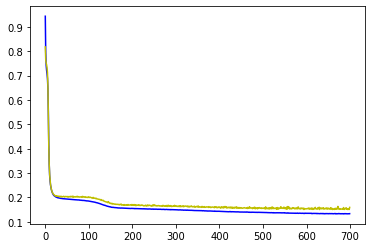

In [25]:
#2. Train this model, to predict temp after one week

model_next_week.apply(weight_reset)
training(700, model_next_week, loss_fn, week_opt, week_train_dl, week_test_dl)

100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  1 loss: 0.83347


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 1 loss: 0.76621


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  2 loss: 0.72275


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 2 loss: 0.76489


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  3 loss: 0.71623


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 3 loss: 0.77490


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  4 loss: 0.71514


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 4 loss: 0.75907


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  5 loss: 0.71383


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 5 loss: 0.76767


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  6 loss: 0.71202


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 6 loss: 0.75571


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  7 loss: 0.70934


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 7 loss: 0.74684


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  8 loss: 0.70442


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 8 loss: 0.77106


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  9 loss: 0.69588


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 9 loss: 0.73707


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  10 loss: 0.67876


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 10 loss: 0.72362


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  11 loss: 0.63855


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 11 loss: 0.66226


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  12 loss: 0.53530


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 12 loss: 0.51579


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  13 loss: 0.36935


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 13 loss: 0.39257


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  14 loss: 0.29623


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 14 loss: 0.35137


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  15 loss: 0.27179


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 15 loss: 0.33881


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  16 loss: 0.25586


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 16 loss: 0.33263


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  17 loss: 0.24677


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 17 loss: 0.32049


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  18 loss: 0.24024


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 18 loss: 0.31230


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  19 loss: 0.23578


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 19 loss: 0.30896


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  20 loss: 0.23231


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 20 loss: 0.29797


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  21 loss: 0.22996


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 21 loss: 0.29993


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  22 loss: 0.22873


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 22 loss: 0.29424


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  23 loss: 0.22750


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 23 loss: 0.29182


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  24 loss: 0.22508


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 24 loss: 0.29162


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  25 loss: 0.22412


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 25 loss: 0.29061


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  26 loss: 0.22453


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 26 loss: 0.28936


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  27 loss: 0.22192


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 27 loss: 0.28187


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  28 loss: 0.22035


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 28 loss: 0.28358


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  29 loss: 0.21899


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 29 loss: 0.28024


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  30 loss: 0.21838


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 30 loss: 0.28267


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  31 loss: 0.21711


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 31 loss: 0.27985


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  32 loss: 0.21496


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 32 loss: 0.27943


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  33 loss: 0.21377


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 33 loss: 0.27379


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  34 loss: 0.21256


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 34 loss: 0.27719


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  35 loss: 0.21039


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 35 loss: 0.27266


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  36 loss: 0.20883


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 36 loss: 0.26652


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  37 loss: 0.20701


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 37 loss: 0.27371


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  38 loss: 0.20559


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 38 loss: 0.26938


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  39 loss: 0.20499


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 39 loss: 0.25966


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  40 loss: 0.20349


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 40 loss: 0.26358


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  41 loss: 0.20139


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 41 loss: 0.26086


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  42 loss: 0.19960


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 42 loss: 0.25874


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  43 loss: 0.19777


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 43 loss: 0.26276


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  44 loss: 0.19462


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 44 loss: 0.25845


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  45 loss: 0.19451


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 45 loss: 0.26049


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  46 loss: 0.19301


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 46 loss: 0.25001


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  47 loss: 0.19136


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 47 loss: 0.24387


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  48 loss: 0.19059


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 48 loss: 0.24425


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  49 loss: 0.18811


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 49 loss: 0.24215


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  50 loss: 0.18749


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 50 loss: 0.24236


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  51 loss: 0.18510


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 51 loss: 0.24207


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  52 loss: 0.18605


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 52 loss: 0.23656


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  53 loss: 0.18373


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 53 loss: 0.23950


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  54 loss: 0.18163


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 54 loss: 0.25086


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  55 loss: 0.17927


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 55 loss: 0.23002


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  56 loss: 0.17954


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 56 loss: 0.22729


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  57 loss: 0.17733


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 57 loss: 0.23403


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  58 loss: 0.17718


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 58 loss: 0.22758


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  59 loss: 0.17357


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 59 loss: 0.22612


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  60 loss: 0.17334


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 60 loss: 0.21922


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  61 loss: 0.17542


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 61 loss: 0.21949


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  62 loss: 0.17244


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 62 loss: 0.23140


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  63 loss: 0.17011


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 63 loss: 0.21457


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  64 loss: 0.16974


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 64 loss: 0.22621


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  65 loss: 0.16908


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 65 loss: 0.23156


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  66 loss: 0.16777


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 66 loss: 0.21340


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  67 loss: 0.16738


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 67 loss: 0.21300


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  68 loss: 0.16587


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 68 loss: 0.21386


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  69 loss: 0.16691


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 69 loss: 0.22458


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  70 loss: 0.16538


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 70 loss: 0.22234


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  71 loss: 0.16539


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 71 loss: 0.21600


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  72 loss: 0.16228


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 72 loss: 0.21911


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  73 loss: 0.16319


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 73 loss: 0.22505


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  74 loss: 0.16277


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 74 loss: 0.21784


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  75 loss: 0.16214


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 75 loss: 0.22550


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  76 loss: 0.16118


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 76 loss: 0.21543


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  77 loss: 0.16167


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 77 loss: 0.20892


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  78 loss: 0.16082


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 78 loss: 0.21816


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  79 loss: 0.15808


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 79 loss: 0.21775


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  80 loss: 0.15880


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 80 loss: 0.20073


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  81 loss: 0.15758


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 81 loss: 0.20655


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  82 loss: 0.15750


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 82 loss: 0.22775


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  83 loss: 0.15676


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 83 loss: 0.20781


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  84 loss: 0.15655


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 84 loss: 0.20131


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  85 loss: 0.15590


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 85 loss: 0.22116


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  86 loss: 0.15583


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 86 loss: 0.21313


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  87 loss: 0.15565


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 87 loss: 0.20737


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  88 loss: 0.15420


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 88 loss: 0.21680


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  89 loss: 0.15386


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 89 loss: 0.20841


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  90 loss: 0.15458


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 90 loss: 0.19846


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  91 loss: 0.15290


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 91 loss: 0.21751


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  92 loss: 0.15316


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 92 loss: 0.20256


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  93 loss: 0.15272


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 93 loss: 0.22845


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  94 loss: 0.15281


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 94 loss: 0.21993


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  95 loss: 0.15184


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 95 loss: 0.20134


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  96 loss: 0.15304


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 96 loss: 0.20685


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  97 loss: 0.15193


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 97 loss: 0.21285


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  98 loss: 0.15157


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 98 loss: 0.20536


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  99 loss: 0.15239


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 99 loss: 0.21359


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  100 loss: 0.15139


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 100 loss: 0.21493


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  101 loss: 0.15134


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 101 loss: 0.20078


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  102 loss: 0.15098


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 102 loss: 0.20258


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  103 loss: 0.15138


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 103 loss: 0.20357


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  104 loss: 0.14898


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 104 loss: 0.21532


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  105 loss: 0.15001


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 105 loss: 0.20217


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  106 loss: 0.14948


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 106 loss: 0.20611


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  107 loss: 0.14912


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 107 loss: 0.20013


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  108 loss: 0.14926


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 108 loss: 0.19610


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  109 loss: 0.14940


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 109 loss: 0.19381


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  110 loss: 0.15075


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 110 loss: 0.20502


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  111 loss: 0.14830


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 111 loss: 0.20001


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  112 loss: 0.14770


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 112 loss: 0.20758


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  113 loss: 0.14861


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 113 loss: 0.20815


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  114 loss: 0.14829


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 114 loss: 0.19825


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  115 loss: 0.14804


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 115 loss: 0.19506


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  116 loss: 0.14722


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 116 loss: 0.20196


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  117 loss: 0.14624


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 117 loss: 0.21711


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  118 loss: 0.14857


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 118 loss: 0.20382


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  119 loss: 0.14799


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 119 loss: 0.19789


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  120 loss: 0.14797


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 120 loss: 0.19191


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  121 loss: 0.14696


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 121 loss: 0.19849


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  122 loss: 0.14713


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 122 loss: 0.21649


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  123 loss: 0.14683


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 123 loss: 0.19647


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  124 loss: 0.14705


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 124 loss: 0.19290


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  125 loss: 0.14663


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 125 loss: 0.19384


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  126 loss: 0.14627


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 126 loss: 0.20258


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  127 loss: 0.14729


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 127 loss: 0.21146


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  128 loss: 0.14644


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 128 loss: 0.20122


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  129 loss: 0.14614


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 129 loss: 0.21962


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  130 loss: 0.14604


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 130 loss: 0.19602


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  131 loss: 0.14494


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 131 loss: 0.19038


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  132 loss: 0.14446


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 132 loss: 0.20616


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  133 loss: 0.14523


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 133 loss: 0.19073


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  134 loss: 0.14647


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 134 loss: 0.21296


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  135 loss: 0.14723


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 135 loss: 0.20819


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  136 loss: 0.14551


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 136 loss: 0.20621


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  137 loss: 0.14463


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 137 loss: 0.19832


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  138 loss: 0.14592


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 138 loss: 0.20720


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  139 loss: 0.14500


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 139 loss: 0.19118


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  140 loss: 0.14478


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 140 loss: 0.19426


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  141 loss: 0.14484


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 141 loss: 0.18761


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  142 loss: 0.14403


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 142 loss: 0.19896


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  143 loss: 0.14472


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 143 loss: 0.18897


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  144 loss: 0.14454


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 144 loss: 0.19503


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  145 loss: 0.14364


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 145 loss: 0.21140


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  146 loss: 0.14516


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 146 loss: 0.20837


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  147 loss: 0.14617


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 147 loss: 0.18912


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  148 loss: 0.14499


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 148 loss: 0.20464


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  149 loss: 0.14475


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 149 loss: 0.20101


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  150 loss: 0.14386


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 150 loss: 0.18628


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  151 loss: 0.14576


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 151 loss: 0.20022


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  152 loss: 0.14343


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 152 loss: 0.19713


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  153 loss: 0.14418


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 153 loss: 0.20661


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  154 loss: 0.14428


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 154 loss: 0.19706


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  155 loss: 0.14415


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 155 loss: 0.19690


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  156 loss: 0.14340


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 156 loss: 0.20281


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  157 loss: 0.14442


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 157 loss: 0.18566


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  158 loss: 0.14424


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 158 loss: 0.19700


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  159 loss: 0.14426


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 159 loss: 0.20276


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  160 loss: 0.14496


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 160 loss: 0.18693


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  161 loss: 0.14319


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 161 loss: 0.19288


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  162 loss: 0.14319


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 162 loss: 0.21039


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  163 loss: 0.14324


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 163 loss: 0.19508


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  164 loss: 0.14414


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 164 loss: 0.20518


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  165 loss: 0.14404


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 165 loss: 0.20187


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  166 loss: 0.14307


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 166 loss: 0.20372


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  167 loss: 0.14595


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 167 loss: 0.19974


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  168 loss: 0.14390


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 168 loss: 0.20787


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  169 loss: 0.14253


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 169 loss: 0.23051


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  170 loss: 0.14450


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 170 loss: 0.19755


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  171 loss: 0.14295


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 171 loss: 0.19480


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  172 loss: 0.14362


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 172 loss: 0.20583


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  173 loss: 0.14376


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 173 loss: 0.19551


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  174 loss: 0.14362


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 174 loss: 0.19415


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  175 loss: 0.14315


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 175 loss: 0.19554


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  176 loss: 0.14328


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 176 loss: 0.18310


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  177 loss: 0.14305


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 177 loss: 0.18039


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  178 loss: 0.14380


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 178 loss: 0.20054


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  179 loss: 0.14315


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 179 loss: 0.19452


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  180 loss: 0.14300


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 180 loss: 0.19595


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  181 loss: 0.14409


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 181 loss: 0.21207


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  182 loss: 0.14358


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 182 loss: 0.20730


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  183 loss: 0.14228


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 183 loss: 0.18959


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  184 loss: 0.14211


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 184 loss: 0.21222


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  185 loss: 0.14238


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 185 loss: 0.19147


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  186 loss: 0.14327


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 186 loss: 0.19971


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  187 loss: 0.14467


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 187 loss: 0.19169


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  188 loss: 0.14326


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 188 loss: 0.19214


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  189 loss: 0.14320


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 189 loss: 0.20792


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  190 loss: 0.14245


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 190 loss: 0.18650


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  191 loss: 0.14178


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 191 loss: 0.20482


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  192 loss: 0.14486


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 192 loss: 0.20769


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  193 loss: 0.14350


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 193 loss: 0.20861


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  194 loss: 0.14265


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 194 loss: 0.20294


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  195 loss: 0.14155


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 195 loss: 0.20954


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  196 loss: 0.14283


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 196 loss: 0.19710


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  197 loss: 0.14222


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 197 loss: 0.19652


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  198 loss: 0.14208


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 198 loss: 0.18996


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  199 loss: 0.14329


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 199 loss: 0.20501


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  200 loss: 0.14233


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 200 loss: 0.21394


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  201 loss: 0.14215


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 201 loss: 0.20054


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  202 loss: 0.14334


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 202 loss: 0.22770


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  203 loss: 0.14227


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 203 loss: 0.18812


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  204 loss: 0.14234


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 204 loss: 0.21445


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  205 loss: 0.14148


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 205 loss: 0.19522


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  206 loss: 0.14282


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 206 loss: 0.19289


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  207 loss: 0.14207


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 207 loss: 0.19423


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  208 loss: 0.14066


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 208 loss: 0.18846


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  209 loss: 0.14222


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 209 loss: 0.21019


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  210 loss: 0.14100


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 210 loss: 0.20350


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  211 loss: 0.14286


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 211 loss: 0.18101


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  212 loss: 0.14233


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 212 loss: 0.19299


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  213 loss: 0.14247


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 213 loss: 0.19112


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  214 loss: 0.14042


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 214 loss: 0.20052


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  215 loss: 0.14460


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 215 loss: 0.19102


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  216 loss: 0.14388


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 216 loss: 0.19934


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  217 loss: 0.14103


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 217 loss: 0.18513


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  218 loss: 0.14251


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 218 loss: 0.20132


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  219 loss: 0.14215


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 219 loss: 0.17991


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  220 loss: 0.14358


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 220 loss: 0.20831


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  221 loss: 0.14189


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 221 loss: 0.21393


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  222 loss: 0.14249


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 222 loss: 0.20515


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  223 loss: 0.14093


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 223 loss: 0.19975


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  224 loss: 0.14065


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 224 loss: 0.21022


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  225 loss: 0.14133


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 225 loss: 0.19749


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  226 loss: 0.14180


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 226 loss: 0.17953


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  227 loss: 0.14273


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 227 loss: 0.18778


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  228 loss: 0.14263


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 228 loss: 0.18316


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  229 loss: 0.14245


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 229 loss: 0.18434


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  230 loss: 0.14200


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 230 loss: 0.19577


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  231 loss: 0.14299


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 231 loss: 0.19803


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  232 loss: 0.14155


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 232 loss: 0.18787


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  233 loss: 0.14214


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 233 loss: 0.21337


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  234 loss: 0.14177


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 234 loss: 0.18666


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  235 loss: 0.14170


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 235 loss: 0.19233


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  236 loss: 0.14183


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 236 loss: 0.18604


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  237 loss: 0.14132


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 237 loss: 0.19988


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  238 loss: 0.14225


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 238 loss: 0.19442


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  239 loss: 0.14188


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 239 loss: 0.20634


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  240 loss: 0.14196


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 240 loss: 0.21201


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  241 loss: 0.14339


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 241 loss: 0.18947


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  242 loss: 0.14219


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 242 loss: 0.19240


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  243 loss: 0.14230


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 243 loss: 0.18689


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  244 loss: 0.14181


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 244 loss: 0.19329


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  245 loss: 0.14169


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 245 loss: 0.19957


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  246 loss: 0.14239


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 246 loss: 0.19430


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  247 loss: 0.14172


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 247 loss: 0.20850


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  248 loss: 0.14220


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 248 loss: 0.20283


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  249 loss: 0.14201


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 249 loss: 0.19364


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  250 loss: 0.14140


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 250 loss: 0.19595


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  251 loss: 0.14328


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 251 loss: 0.18397


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  252 loss: 0.14114


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 252 loss: 0.18804


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  253 loss: 0.14071


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 253 loss: 0.21862


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  254 loss: 0.14244


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 254 loss: 0.19201


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  255 loss: 0.14053


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 255 loss: 0.19271


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  256 loss: 0.14149


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 256 loss: 0.20226


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  257 loss: 0.14079


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 257 loss: 0.19329


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  258 loss: 0.14207


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 258 loss: 0.19284


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  259 loss: 0.14113


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 259 loss: 0.18820


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  260 loss: 0.14123


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 260 loss: 0.19351


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  261 loss: 0.14161


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 261 loss: 0.19148


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  262 loss: 0.13994


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 262 loss: 0.19568


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  263 loss: 0.14122


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 263 loss: 0.19289


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  264 loss: 0.14184


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 264 loss: 0.17999


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  265 loss: 0.14218


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 265 loss: 0.19234


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  266 loss: 0.14141


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 266 loss: 0.19103


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  267 loss: 0.14211


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 267 loss: 0.19110


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  268 loss: 0.14198


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 268 loss: 0.19792


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  269 loss: 0.14172


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 269 loss: 0.20532


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  270 loss: 0.14152


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 270 loss: 0.19854


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  271 loss: 0.14118


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 271 loss: 0.20948


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  272 loss: 0.14081


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 272 loss: 0.18839


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  273 loss: 0.14069


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 273 loss: 0.19499


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  274 loss: 0.14195


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 274 loss: 0.19540


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  275 loss: 0.14108


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 275 loss: 0.21365


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  276 loss: 0.14210


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 276 loss: 0.18270


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  277 loss: 0.14138


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 277 loss: 0.20363


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  278 loss: 0.14187


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 278 loss: 0.19308


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  279 loss: 0.14185


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 279 loss: 0.19689


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  280 loss: 0.14223


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 280 loss: 0.19823


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  281 loss: 0.14062


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 281 loss: 0.20256


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  282 loss: 0.14074


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 282 loss: 0.20221


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  283 loss: 0.14166


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 283 loss: 0.20229


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  284 loss: 0.14181


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 284 loss: 0.19870


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  285 loss: 0.14118


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 285 loss: 0.19490


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  286 loss: 0.14118


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 286 loss: 0.20173


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  287 loss: 0.14176


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 287 loss: 0.20012


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  288 loss: 0.14145


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 288 loss: 0.19917


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  289 loss: 0.14013


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 289 loss: 0.20077


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  290 loss: 0.13980


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 290 loss: 0.18652


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  291 loss: 0.14189


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 291 loss: 0.19697


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  292 loss: 0.14123


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 292 loss: 0.19586


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  293 loss: 0.14013


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 293 loss: 0.19511


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  294 loss: 0.14171


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 294 loss: 0.19171


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  295 loss: 0.14133


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 295 loss: 0.20692


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  296 loss: 0.14097


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 296 loss: 0.19338


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  297 loss: 0.14059


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 297 loss: 0.20573


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  298 loss: 0.14150


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 298 loss: 0.19334


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  299 loss: 0.14047


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 299 loss: 0.19860


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  300 loss: 0.14252


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 300 loss: 0.20016


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  301 loss: 0.14011


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 301 loss: 0.19530


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  302 loss: 0.14140


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 302 loss: 0.18979


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  303 loss: 0.14005


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 303 loss: 0.18772


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  304 loss: 0.13975


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 304 loss: 0.20164


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  305 loss: 0.14099


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 305 loss: 0.20513


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  306 loss: 0.14046


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 306 loss: 0.18014


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  307 loss: 0.14222


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 307 loss: 0.21707


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  308 loss: 0.14051


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 308 loss: 0.19316


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  309 loss: 0.14171


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 309 loss: 0.20839


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  310 loss: 0.14108


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 310 loss: 0.19053


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  311 loss: 0.14086


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 311 loss: 0.19452


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  312 loss: 0.14151


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 312 loss: 0.21256


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  313 loss: 0.14141


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 313 loss: 0.18275


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  314 loss: 0.14026


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 314 loss: 0.19395


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  315 loss: 0.13997


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 315 loss: 0.17806


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  316 loss: 0.14218


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 316 loss: 0.21477


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  317 loss: 0.13980


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 317 loss: 0.20571


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  318 loss: 0.13988


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 318 loss: 0.19372


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  319 loss: 0.14319


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 319 loss: 0.18354


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  320 loss: 0.14095


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 320 loss: 0.18775


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  321 loss: 0.14002


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 321 loss: 0.18793


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  322 loss: 0.14096


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 322 loss: 0.19445


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  323 loss: 0.14133


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 323 loss: 0.20782


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  324 loss: 0.14146


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 324 loss: 0.18017


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  325 loss: 0.14030


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 325 loss: 0.18628


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  326 loss: 0.14044


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 326 loss: 0.19345


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  327 loss: 0.14040


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 327 loss: 0.20953


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  328 loss: 0.14089


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 328 loss: 0.18307


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  329 loss: 0.13935


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 329 loss: 0.19779


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  330 loss: 0.14033


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 330 loss: 0.19355


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  331 loss: 0.14117


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 331 loss: 0.19452


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  332 loss: 0.14014


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 332 loss: 0.19526


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  333 loss: 0.14187


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 333 loss: 0.18969


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  334 loss: 0.14072


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 334 loss: 0.18514


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  335 loss: 0.14120


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 335 loss: 0.19037


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  336 loss: 0.14157


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 336 loss: 0.19591


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  337 loss: 0.14089


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 337 loss: 0.19121


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  338 loss: 0.14076


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 338 loss: 0.19712


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  339 loss: 0.14043


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 339 loss: 0.18343


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  340 loss: 0.14152


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 340 loss: 0.18838


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  341 loss: 0.14136


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 341 loss: 0.19354


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  342 loss: 0.13932


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 342 loss: 0.19437


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  343 loss: 0.13870


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 343 loss: 0.19148


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  344 loss: 0.14138


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 344 loss: 0.21408


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  345 loss: 0.14123


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 345 loss: 0.20407


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  346 loss: 0.14036


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 346 loss: 0.20156


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  347 loss: 0.14088


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 347 loss: 0.19684


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  348 loss: 0.14014


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 348 loss: 0.19810


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  349 loss: 0.14085


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 349 loss: 0.18821


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  350 loss: 0.14062


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 350 loss: 0.19422


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  351 loss: 0.14070


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 351 loss: 0.21541


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  352 loss: 0.14011


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 352 loss: 0.18795


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  353 loss: 0.14048


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 353 loss: 0.20304


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  354 loss: 0.14012


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 354 loss: 0.20339


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  355 loss: 0.14023


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 355 loss: 0.23018


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  356 loss: 0.14024


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 356 loss: 0.19408


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  357 loss: 0.13988


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 357 loss: 0.18766


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  358 loss: 0.14087


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 358 loss: 0.20170


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  359 loss: 0.13961


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 359 loss: 0.19659


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  360 loss: 0.14003


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 360 loss: 0.21178


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  361 loss: 0.14184


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 361 loss: 0.19161


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  362 loss: 0.14046


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 362 loss: 0.19928


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  363 loss: 0.14066


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 363 loss: 0.18840


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  364 loss: 0.13944


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 364 loss: 0.20371


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  365 loss: 0.14303


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 365 loss: 0.19567


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  366 loss: 0.14031


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 366 loss: 0.18646


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  367 loss: 0.14070


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 367 loss: 0.19525


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  368 loss: 0.13970


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 368 loss: 0.21740


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  369 loss: 0.13939


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 369 loss: 0.18792


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  370 loss: 0.13956


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 370 loss: 0.19165


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  371 loss: 0.14103


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 371 loss: 0.20576


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  372 loss: 0.14041


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 372 loss: 0.19524


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  373 loss: 0.13946


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 373 loss: 0.19363


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  374 loss: 0.14042


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 374 loss: 0.20605


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  375 loss: 0.14119


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 375 loss: 0.19604


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  376 loss: 0.13991


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 376 loss: 0.18847


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  377 loss: 0.14081


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 377 loss: 0.20492


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  378 loss: 0.14070


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 378 loss: 0.19647


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  379 loss: 0.14099


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 379 loss: 0.18364


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  380 loss: 0.14090


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 380 loss: 0.17889


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  381 loss: 0.14223


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 381 loss: 0.20160


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  382 loss: 0.14093


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 382 loss: 0.18850


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  383 loss: 0.13957


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 383 loss: 0.20333


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  384 loss: 0.14077


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 384 loss: 0.20394


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  385 loss: 0.13989


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 385 loss: 0.19655


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  386 loss: 0.13992


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 386 loss: 0.18126


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  387 loss: 0.14120


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 387 loss: 0.19309


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  388 loss: 0.14046


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 388 loss: 0.18734


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  389 loss: 0.14252


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 389 loss: 0.18947


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  390 loss: 0.14041


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 390 loss: 0.19340


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  391 loss: 0.13996


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 391 loss: 0.19144


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  392 loss: 0.14066


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 392 loss: 0.18604


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  393 loss: 0.14048


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 393 loss: 0.19262


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  394 loss: 0.14148


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 394 loss: 0.18382


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  395 loss: 0.14088


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 395 loss: 0.19170


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  396 loss: 0.14067


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 396 loss: 0.18806


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  397 loss: 0.14079


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 397 loss: 0.18552


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  398 loss: 0.14001


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 398 loss: 0.19119


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  399 loss: 0.14001


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 399 loss: 0.19420


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  400 loss: 0.13980


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 400 loss: 0.18464


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  401 loss: 0.14057


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 401 loss: 0.19109


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  402 loss: 0.13960


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 402 loss: 0.20996


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  403 loss: 0.13987


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 403 loss: 0.17776


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  404 loss: 0.14078


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 404 loss: 0.19816


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  405 loss: 0.13888


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 405 loss: 0.20670


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  406 loss: 0.14056


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 406 loss: 0.17550


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  407 loss: 0.14103


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 407 loss: 0.20481


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  408 loss: 0.14001


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 408 loss: 0.18109


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  409 loss: 0.14101


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 409 loss: 0.18832


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  410 loss: 0.14135


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 410 loss: 0.19435


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  411 loss: 0.13995


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 411 loss: 0.17787


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  412 loss: 0.14045


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 412 loss: 0.20128


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  413 loss: 0.14063


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 413 loss: 0.20445


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  414 loss: 0.13973


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 414 loss: 0.20612


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  415 loss: 0.13969


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 415 loss: 0.19277


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  416 loss: 0.14095


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 416 loss: 0.18608


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  417 loss: 0.13936


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 417 loss: 0.18119


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  418 loss: 0.14156


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 418 loss: 0.19900


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  419 loss: 0.14107


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 419 loss: 0.20829


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  420 loss: 0.14049


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 420 loss: 0.19387


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  421 loss: 0.14015


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 421 loss: 0.20671


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  422 loss: 0.14062


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 422 loss: 0.20681


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  423 loss: 0.13913


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 423 loss: 0.21050


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  424 loss: 0.13983


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 424 loss: 0.19840


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  425 loss: 0.14096


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 425 loss: 0.20067


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  426 loss: 0.14059


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 426 loss: 0.18771


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  427 loss: 0.13991


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 427 loss: 0.19717


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  428 loss: 0.14009


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 428 loss: 0.19741


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  429 loss: 0.14019


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 429 loss: 0.18485


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  430 loss: 0.14013


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 430 loss: 0.19279


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  431 loss: 0.13966


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 431 loss: 0.19643


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  432 loss: 0.14035


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 432 loss: 0.20376


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  433 loss: 0.13977


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 433 loss: 0.18527


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  434 loss: 0.13986


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 434 loss: 0.19913


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  435 loss: 0.13942


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 435 loss: 0.20235


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  436 loss: 0.13963


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 436 loss: 0.18671


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  437 loss: 0.13938


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 437 loss: 0.19077


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  438 loss: 0.13951


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 438 loss: 0.19067


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  439 loss: 0.14102


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 439 loss: 0.17605


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  440 loss: 0.14030


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 440 loss: 0.22210


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  441 loss: 0.14153


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 441 loss: 0.19527


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  442 loss: 0.14080


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 442 loss: 0.19043


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  443 loss: 0.14071


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 443 loss: 0.18728


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  444 loss: 0.13923


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 444 loss: 0.19255


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  445 loss: 0.14053


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 445 loss: 0.19394


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  446 loss: 0.14053


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 446 loss: 0.18911


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  447 loss: 0.14235


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 447 loss: 0.19216


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  448 loss: 0.13922


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 448 loss: 0.20925


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  449 loss: 0.14032


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 449 loss: 0.19138


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  450 loss: 0.13968


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 450 loss: 0.19539


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  451 loss: 0.14188


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 451 loss: 0.18338


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  452 loss: 0.14041


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 452 loss: 0.19294


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  453 loss: 0.14176


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 453 loss: 0.20513


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  454 loss: 0.14023


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 454 loss: 0.19571


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  455 loss: 0.13998


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 455 loss: 0.18287


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  456 loss: 0.14016


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 456 loss: 0.19776


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  457 loss: 0.14096


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 457 loss: 0.20142


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  458 loss: 0.13921


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 458 loss: 0.19161


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  459 loss: 0.13954


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 459 loss: 0.19086


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  460 loss: 0.13952


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 460 loss: 0.21470


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  461 loss: 0.13987


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 461 loss: 0.19852


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  462 loss: 0.14091


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 462 loss: 0.21050


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  463 loss: 0.14024


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 463 loss: 0.18809


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  464 loss: 0.13972


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 464 loss: 0.18882


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  465 loss: 0.14130


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 465 loss: 0.18124


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  466 loss: 0.14043


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 466 loss: 0.19167


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  467 loss: 0.14054


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 467 loss: 0.18279


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  468 loss: 0.14146


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 468 loss: 0.18756


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  469 loss: 0.13926


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 469 loss: 0.18098


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  470 loss: 0.14024


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 470 loss: 0.19196


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  471 loss: 0.13953


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 471 loss: 0.20557


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  472 loss: 0.13978


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 472 loss: 0.21170


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  473 loss: 0.13942


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 473 loss: 0.20090


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  474 loss: 0.14086


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 474 loss: 0.21347


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  475 loss: 0.14126


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 475 loss: 0.19983


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  476 loss: 0.14050


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 476 loss: 0.18569


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  477 loss: 0.13930


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 477 loss: 0.19475


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  478 loss: 0.14069


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 478 loss: 0.18153


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  479 loss: 0.14004


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 479 loss: 0.18695


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  480 loss: 0.13983


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 480 loss: 0.17443


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  481 loss: 0.14114


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 481 loss: 0.20666


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  482 loss: 0.13947


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 482 loss: 0.20955


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  483 loss: 0.13950


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 483 loss: 0.20125


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  484 loss: 0.13857


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 484 loss: 0.19103


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  485 loss: 0.14010


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 485 loss: 0.19240


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  486 loss: 0.13918


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 486 loss: 0.19296


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  487 loss: 0.13874


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 487 loss: 0.19890


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  488 loss: 0.13912


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 488 loss: 0.22732


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  489 loss: 0.13983


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 489 loss: 0.21479


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  490 loss: 0.14032


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 490 loss: 0.18637


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  491 loss: 0.14071


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 491 loss: 0.19197


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  492 loss: 0.13984


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 492 loss: 0.17850


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  493 loss: 0.13900


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 493 loss: 0.19555


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  494 loss: 0.13940


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 494 loss: 0.19058


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  495 loss: 0.13959


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 495 loss: 0.21392


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  496 loss: 0.14074


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 496 loss: 0.20236


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  497 loss: 0.13914


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 497 loss: 0.18819


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  498 loss: 0.13861


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 498 loss: 0.19516


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  499 loss: 0.13932


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 499 loss: 0.20193


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  500 loss: 0.13905


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 500 loss: 0.19562


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  501 loss: 0.13989


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 501 loss: 0.18640


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  502 loss: 0.14116


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 502 loss: 0.17753


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  503 loss: 0.14107


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 503 loss: 0.18538


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  504 loss: 0.13948


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 504 loss: 0.18969


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  505 loss: 0.13997


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 505 loss: 0.19503


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  506 loss: 0.13983


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 506 loss: 0.18585


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  507 loss: 0.13906


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 507 loss: 0.19908


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  508 loss: 0.14068


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 508 loss: 0.18877


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  509 loss: 0.14045


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 509 loss: 0.18546


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  510 loss: 0.13954


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 510 loss: 0.19622


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  511 loss: 0.14013


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 511 loss: 0.18743


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  512 loss: 0.14085


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 512 loss: 0.21736


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  513 loss: 0.14037


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 513 loss: 0.19692


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  514 loss: 0.13913


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 514 loss: 0.19914


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  515 loss: 0.13927


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 515 loss: 0.18596


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  516 loss: 0.14117


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 516 loss: 0.18402


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  517 loss: 0.13923


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 517 loss: 0.18851


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  518 loss: 0.13959


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 518 loss: 0.20879


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  519 loss: 0.14005


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 519 loss: 0.19656


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  520 loss: 0.13988


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 520 loss: 0.19622


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  521 loss: 0.13897


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 521 loss: 0.18567


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  522 loss: 0.14075


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 522 loss: 0.19569


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  523 loss: 0.13877


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 523 loss: 0.19465


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  524 loss: 0.14054


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 524 loss: 0.19422


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  525 loss: 0.13926


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 525 loss: 0.21166


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  526 loss: 0.14078


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 526 loss: 0.19305


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  527 loss: 0.13971


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 527 loss: 0.19303


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  528 loss: 0.13989


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 528 loss: 0.19590


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  529 loss: 0.13928


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 529 loss: 0.19587


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  530 loss: 0.14026


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 530 loss: 0.18026


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  531 loss: 0.14006


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 531 loss: 0.18944


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  532 loss: 0.13915


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 532 loss: 0.18830


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  533 loss: 0.14017


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 533 loss: 0.18471


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  534 loss: 0.14031


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 534 loss: 0.20590


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  535 loss: 0.13985


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 535 loss: 0.19266


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  536 loss: 0.14108


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 536 loss: 0.20790


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  537 loss: 0.14063


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 537 loss: 0.19421


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  538 loss: 0.13967


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 538 loss: 0.19061


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  539 loss: 0.13982


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 539 loss: 0.21246


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  540 loss: 0.14113


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 540 loss: 0.18944


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  541 loss: 0.13928


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 541 loss: 0.20576


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  542 loss: 0.13979


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 542 loss: 0.18486


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  543 loss: 0.14139


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 543 loss: 0.20586


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  544 loss: 0.14008


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 544 loss: 0.18205


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  545 loss: 0.13897


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 545 loss: 0.20382


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  546 loss: 0.14045


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 546 loss: 0.18616


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  547 loss: 0.13898


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 547 loss: 0.19693


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  548 loss: 0.13948


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 548 loss: 0.21273


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  549 loss: 0.13988


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 549 loss: 0.20136


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  550 loss: 0.13972


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 550 loss: 0.19030


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  551 loss: 0.13924


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 551 loss: 0.19430


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  552 loss: 0.13959


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 552 loss: 0.20224


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  553 loss: 0.14044


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 553 loss: 0.19163


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  554 loss: 0.14041


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 554 loss: 0.20794


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  555 loss: 0.13915


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 555 loss: 0.19407


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  556 loss: 0.13962


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 556 loss: 0.20515


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  557 loss: 0.13954


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 557 loss: 0.17960


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  558 loss: 0.13971


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 558 loss: 0.19464


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  559 loss: 0.13912


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 559 loss: 0.18731


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  560 loss: 0.14051


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 560 loss: 0.18574


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  561 loss: 0.13858


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 561 loss: 0.18898


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  562 loss: 0.13993


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 562 loss: 0.21840


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  563 loss: 0.13957


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 563 loss: 0.20141


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  564 loss: 0.14121


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 564 loss: 0.18433


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  565 loss: 0.14032


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 565 loss: 0.18947


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  566 loss: 0.13924


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 566 loss: 0.17752


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  567 loss: 0.13863


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 567 loss: 0.22388


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  568 loss: 0.13974


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 568 loss: 0.18845


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  569 loss: 0.13952


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 569 loss: 0.19440


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  570 loss: 0.14033


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 570 loss: 0.19053


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  571 loss: 0.14001


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 571 loss: 0.19077


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  572 loss: 0.13803


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 572 loss: 0.18610


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  573 loss: 0.13902


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 573 loss: 0.19890


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  574 loss: 0.13988


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 574 loss: 0.20616


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  575 loss: 0.13900


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 575 loss: 0.18865


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  576 loss: 0.13898


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 576 loss: 0.19167


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  577 loss: 0.13992


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 577 loss: 0.19491


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  578 loss: 0.13919


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 578 loss: 0.20394


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  579 loss: 0.14035


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 579 loss: 0.19327


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  580 loss: 0.14007


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 580 loss: 0.18866


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  581 loss: 0.13946


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 581 loss: 0.18874


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  582 loss: 0.13919


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 582 loss: 0.19535


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  583 loss: 0.14033


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 583 loss: 0.19541


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  584 loss: 0.13971


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 584 loss: 0.21750


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  585 loss: 0.13935


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 585 loss: 0.17474


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  586 loss: 0.14111


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 586 loss: 0.19341


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  587 loss: 0.14129


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 587 loss: 0.18493


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  588 loss: 0.14122


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 588 loss: 0.18470


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  589 loss: 0.13922


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 589 loss: 0.19453


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  590 loss: 0.13961


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 590 loss: 0.18825


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  591 loss: 0.14004


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 591 loss: 0.19193


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  592 loss: 0.14040


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 592 loss: 0.18691


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  593 loss: 0.13876


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 593 loss: 0.18418


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  594 loss: 0.13915


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 594 loss: 0.19197


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  595 loss: 0.13855


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 595 loss: 0.22877


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  596 loss: 0.14107


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 596 loss: 0.18610


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  597 loss: 0.14081


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 597 loss: 0.19667


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  598 loss: 0.13983


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 598 loss: 0.19855


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  599 loss: 0.14065


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 599 loss: 0.20811


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  600 loss: 0.14104


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 600 loss: 0.18235


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  601 loss: 0.14011


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 601 loss: 0.20028


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  602 loss: 0.13901


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 602 loss: 0.19985


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  603 loss: 0.13959


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 603 loss: 0.19271


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  604 loss: 0.13970


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 604 loss: 0.18543


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  605 loss: 0.14049


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 605 loss: 0.19084


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  606 loss: 0.14053


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 606 loss: 0.18865


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  607 loss: 0.13946


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 607 loss: 0.20202


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  608 loss: 0.14033


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 608 loss: 0.20260


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  609 loss: 0.13977


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 609 loss: 0.19662


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  610 loss: 0.13841


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 610 loss: 0.20158


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  611 loss: 0.13888


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 611 loss: 0.19295


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  612 loss: 0.13855


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 612 loss: 0.21000


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  613 loss: 0.13910


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 613 loss: 0.19055


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  614 loss: 0.13995


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 614 loss: 0.18990


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  615 loss: 0.14090


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 615 loss: 0.19397


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  616 loss: 0.14005


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 616 loss: 0.19243


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  617 loss: 0.13895


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 617 loss: 0.19438


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  618 loss: 0.13929


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 618 loss: 0.20174


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  619 loss: 0.13999


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 619 loss: 0.18804


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  620 loss: 0.14003


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 620 loss: 0.17868


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  621 loss: 0.13919


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 621 loss: 0.18218


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  622 loss: 0.14009


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 622 loss: 0.20732


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  623 loss: 0.14018


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 623 loss: 0.20195


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  624 loss: 0.14048


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 624 loss: 0.20100


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  625 loss: 0.13915


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 625 loss: 0.18206


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  626 loss: 0.14044


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 626 loss: 0.18230


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  627 loss: 0.14019


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 627 loss: 0.20204


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  628 loss: 0.14004


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 628 loss: 0.18910


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  629 loss: 0.13977


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 629 loss: 0.18870


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  630 loss: 0.14017


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 630 loss: 0.20481


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  631 loss: 0.13969


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 631 loss: 0.19797


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  632 loss: 0.13991


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 632 loss: 0.17345


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  633 loss: 0.13909


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 633 loss: 0.19890


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  634 loss: 0.13973


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 634 loss: 0.20278


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  635 loss: 0.14127


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 635 loss: 0.19234


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  636 loss: 0.13845


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 636 loss: 0.17639


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  637 loss: 0.14123


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 637 loss: 0.20211


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  638 loss: 0.13935


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 638 loss: 0.20650


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  639 loss: 0.14058


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 639 loss: 0.19283


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  640 loss: 0.13879


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 640 loss: 0.21314


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  641 loss: 0.14142


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 641 loss: 0.18240


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  642 loss: 0.14032


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 642 loss: 0.19853


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  643 loss: 0.13916


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 643 loss: 0.19773


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  644 loss: 0.13932


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 644 loss: 0.18980


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  645 loss: 0.13856


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 645 loss: 0.20787


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  646 loss: 0.13884


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 646 loss: 0.19025


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  647 loss: 0.13879


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 647 loss: 0.18584


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  648 loss: 0.13956


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 648 loss: 0.20087


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  649 loss: 0.13964


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 649 loss: 0.18866


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  650 loss: 0.14022


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 650 loss: 0.20053


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  651 loss: 0.13961


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 651 loss: 0.20472


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  652 loss: 0.13958


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 652 loss: 0.19192


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  653 loss: 0.13986


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 653 loss: 0.18669


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  654 loss: 0.13984


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 654 loss: 0.18764


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  655 loss: 0.13927


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 655 loss: 0.20244


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  656 loss: 0.14014


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 656 loss: 0.19155


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  657 loss: 0.13956


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 657 loss: 0.20289


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  658 loss: 0.13982


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 658 loss: 0.20264


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  659 loss: 0.13918


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 659 loss: 0.21275


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  660 loss: 0.13959


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 660 loss: 0.20560


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  661 loss: 0.13924


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 661 loss: 0.21109


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  662 loss: 0.13973


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 662 loss: 0.18257


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  663 loss: 0.13832


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 663 loss: 0.19631


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  664 loss: 0.13956


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 664 loss: 0.19427


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  665 loss: 0.13930


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 665 loss: 0.19696


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  666 loss: 0.13942


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 666 loss: 0.19355


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  667 loss: 0.13979


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 667 loss: 0.19105


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  668 loss: 0.14006


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 668 loss: 0.19461


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  669 loss: 0.13814


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 669 loss: 0.19672


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  670 loss: 0.13917


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 670 loss: 0.20347


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  671 loss: 0.13848


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 671 loss: 0.20540


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  672 loss: 0.13955


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 672 loss: 0.21524


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  673 loss: 0.13994


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 673 loss: 0.18676


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  674 loss: 0.14167


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 674 loss: 0.20217


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  675 loss: 0.13956


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 675 loss: 0.19378


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  676 loss: 0.13972


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 676 loss: 0.18487


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  677 loss: 0.13905


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 677 loss: 0.17795


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  678 loss: 0.13869


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 678 loss: 0.18794


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  679 loss: 0.14119


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 679 loss: 0.21207


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  680 loss: 0.14040


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 680 loss: 0.18771


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  681 loss: 0.14094


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 681 loss: 0.19054


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  682 loss: 0.13856


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 682 loss: 0.19984


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  683 loss: 0.13873


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 683 loss: 0.18258


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  684 loss: 0.13901


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 684 loss: 0.19787


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  685 loss: 0.13878


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 685 loss: 0.19609


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  686 loss: 0.13910


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 686 loss: 0.18396


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  687 loss: 0.13881


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 687 loss: 0.20543


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  688 loss: 0.13881


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 688 loss: 0.17668


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  689 loss: 0.13906


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 689 loss: 0.17922


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  690 loss: 0.14010


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 690 loss: 0.18970


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  691 loss: 0.14039


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 691 loss: 0.19722


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  692 loss: 0.13915


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 692 loss: 0.18633


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  693 loss: 0.13854


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 693 loss: 0.19584


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  694 loss: 0.13881


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 694 loss: 0.18303


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  695 loss: 0.13853


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 695 loss: 0.19032


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  696 loss: 0.13898


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 696 loss: 0.18052


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  697 loss: 0.13988


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 697 loss: 0.20358


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  698 loss: 0.13963


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 698 loss: 0.19435


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  699 loss: 0.13968


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 699 loss: 0.21002


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  700 loss: 0.13964


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 700 loss: 0.20075


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  701 loss: 0.14171


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 701 loss: 0.19461


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  702 loss: 0.13874


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 702 loss: 0.20300


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  703 loss: 0.13942


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 703 loss: 0.19639


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  704 loss: 0.14054


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 704 loss: 0.20932


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  705 loss: 0.14030


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 705 loss: 0.20637


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  706 loss: 0.13997


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 706 loss: 0.18305


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  707 loss: 0.13985


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 707 loss: 0.18158


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  708 loss: 0.13929


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 708 loss: 0.20131


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  709 loss: 0.13917


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 709 loss: 0.18967


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  710 loss: 0.13922


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 710 loss: 0.19402


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  711 loss: 0.13926


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 711 loss: 0.18612


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  712 loss: 0.13878


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 712 loss: 0.19487


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  713 loss: 0.13954


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 713 loss: 0.19150


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  714 loss: 0.13948


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 714 loss: 0.18323


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  715 loss: 0.14064


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 715 loss: 0.19160


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  716 loss: 0.13972


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 716 loss: 0.20473


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  717 loss: 0.13960


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 717 loss: 0.19630


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  718 loss: 0.13991


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 718 loss: 0.20118


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  719 loss: 0.13909


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 719 loss: 0.19006


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  720 loss: 0.13973


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 720 loss: 0.18402


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  721 loss: 0.13876


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 721 loss: 0.19151


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  722 loss: 0.13898


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 722 loss: 0.19394


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  723 loss: 0.13944


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 723 loss: 0.21555


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  724 loss: 0.13785


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 724 loss: 0.21600


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  725 loss: 0.13944


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 725 loss: 0.18437


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  726 loss: 0.13925


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 726 loss: 0.19982


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  727 loss: 0.13996


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 727 loss: 0.18040


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  728 loss: 0.13886


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 728 loss: 0.20141


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  729 loss: 0.13914


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 729 loss: 0.19888


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  730 loss: 0.13968


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 730 loss: 0.19019


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  731 loss: 0.14024


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 731 loss: 0.18160


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  732 loss: 0.13975


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 732 loss: 0.18436


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  733 loss: 0.13860


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 733 loss: 0.19195


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  734 loss: 0.13875


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 734 loss: 0.17825


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  735 loss: 0.13943


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 735 loss: 0.18390


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  736 loss: 0.14148


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 736 loss: 0.18873


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  737 loss: 0.13922


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 737 loss: 0.20073


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  738 loss: 0.13989


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 738 loss: 0.18874


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  739 loss: 0.14030


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 739 loss: 0.18883


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  740 loss: 0.13903


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 740 loss: 0.19501


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  741 loss: 0.13958


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 741 loss: 0.20314


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  742 loss: 0.13957


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 742 loss: 0.19928


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  743 loss: 0.13900


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 743 loss: 0.20456


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  744 loss: 0.13938


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 744 loss: 0.20079


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  745 loss: 0.13875


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 745 loss: 0.20408


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  746 loss: 0.13933


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 746 loss: 0.19289


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  747 loss: 0.13846


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 747 loss: 0.20051


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  748 loss: 0.14037


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 748 loss: 0.19595


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  749 loss: 0.14036


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 749 loss: 0.18589


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  750 loss: 0.14018


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 750 loss: 0.20513


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  751 loss: 0.14025


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 751 loss: 0.19193


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  752 loss: 0.13956


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 752 loss: 0.19084


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  753 loss: 0.13907


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 753 loss: 0.19869


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  754 loss: 0.13931


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 754 loss: 0.19136


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  755 loss: 0.14007


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 755 loss: 0.20761


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  756 loss: 0.14055


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 756 loss: 0.19122


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  757 loss: 0.13960


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 757 loss: 0.20117


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  758 loss: 0.13982


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 758 loss: 0.20913


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  759 loss: 0.13852


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 759 loss: 0.20489


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  760 loss: 0.14020


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 760 loss: 0.18014


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  761 loss: 0.13949


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 761 loss: 0.19697


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  762 loss: 0.13785


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 762 loss: 0.19743


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  763 loss: 0.13968


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 763 loss: 0.21393


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  764 loss: 0.13872


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 764 loss: 0.18997


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  765 loss: 0.14087


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 765 loss: 0.18880


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  766 loss: 0.13870


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 766 loss: 0.19334


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  767 loss: 0.13956


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 767 loss: 0.19286


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  768 loss: 0.13980


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 768 loss: 0.19527


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  769 loss: 0.13920


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 769 loss: 0.19206


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  770 loss: 0.13820


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 770 loss: 0.20482


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  771 loss: 0.13967


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 771 loss: 0.20844


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  772 loss: 0.14056


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 772 loss: 0.19185


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  773 loss: 0.14001


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 773 loss: 0.18862


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  774 loss: 0.14020


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 774 loss: 0.19070


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  775 loss: 0.13884


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 775 loss: 0.19337


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  776 loss: 0.13990


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 776 loss: 0.19403


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  777 loss: 0.13930


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 777 loss: 0.19274


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  778 loss: 0.13910


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 778 loss: 0.22202


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  779 loss: 0.13954


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 779 loss: 0.21362


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  780 loss: 0.13784


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 780 loss: 0.21689


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  781 loss: 0.13966


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 781 loss: 0.19593


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  782 loss: 0.13874


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 782 loss: 0.19339


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  783 loss: 0.13943


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 783 loss: 0.19351


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  784 loss: 0.13880


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 784 loss: 0.18657


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  785 loss: 0.13989


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 785 loss: 0.19998


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  786 loss: 0.13881


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 786 loss: 0.19612


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  787 loss: 0.13915


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 787 loss: 0.20561


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  788 loss: 0.14008


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 788 loss: 0.18892


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  789 loss: 0.13983


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 789 loss: 0.19582


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  790 loss: 0.13896


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 790 loss: 0.18854


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  791 loss: 0.14083


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 791 loss: 0.18198


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  792 loss: 0.13973


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 792 loss: 0.21315


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  793 loss: 0.13971


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 793 loss: 0.18337


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  794 loss: 0.13918


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 794 loss: 0.18651


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  795 loss: 0.13847


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 795 loss: 0.18323


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  796 loss: 0.13893


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 796 loss: 0.19175


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  797 loss: 0.13834


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 797 loss: 0.22439


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  798 loss: 0.14119


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 798 loss: 0.19291


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  799 loss: 0.13964


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 799 loss: 0.18744


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  800 loss: 0.13949


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 800 loss: 0.18604


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  801 loss: 0.13898


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 801 loss: 0.18902


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  802 loss: 0.13903


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 802 loss: 0.19118


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  803 loss: 0.13936


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 803 loss: 0.20860


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  804 loss: 0.13904


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 804 loss: 0.19732


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  805 loss: 0.13884


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 805 loss: 0.19009


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  806 loss: 0.13913


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 806 loss: 0.19726


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  807 loss: 0.13924


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 807 loss: 0.19733


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  808 loss: 0.14011


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 808 loss: 0.18870


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  809 loss: 0.13982


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 809 loss: 0.19064


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  810 loss: 0.13874


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 810 loss: 0.18834


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  811 loss: 0.13805


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 811 loss: 0.19441


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  812 loss: 0.13943


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 812 loss: 0.18838


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  813 loss: 0.13879


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 813 loss: 0.19587


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  814 loss: 0.13905


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 814 loss: 0.19496


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  815 loss: 0.13963


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 815 loss: 0.20421


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  816 loss: 0.13868


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 816 loss: 0.20794


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  817 loss: 0.13958


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 817 loss: 0.18845


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  818 loss: 0.13879


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 818 loss: 0.18967


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  819 loss: 0.13913


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 819 loss: 0.19900


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  820 loss: 0.13979


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 820 loss: 0.20055


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  821 loss: 0.14036


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 821 loss: 0.19025


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  822 loss: 0.13880


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 822 loss: 0.18893


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  823 loss: 0.13989


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 823 loss: 0.21457


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  824 loss: 0.14002


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 824 loss: 0.18783


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  825 loss: 0.13951


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 825 loss: 0.19021


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  826 loss: 0.13915


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 826 loss: 0.19885


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  827 loss: 0.14042


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 827 loss: 0.17974


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  828 loss: 0.13949


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 828 loss: 0.19425


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  829 loss: 0.13865


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 829 loss: 0.19019


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  830 loss: 0.13948


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 830 loss: 0.18758


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  831 loss: 0.13973


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 831 loss: 0.20986


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  832 loss: 0.14015


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 832 loss: 0.18407


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  833 loss: 0.13948


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 833 loss: 0.19159


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  834 loss: 0.13965


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 834 loss: 0.20149


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  835 loss: 0.14043


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 835 loss: 0.20518


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  836 loss: 0.13944


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 836 loss: 0.20686


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  837 loss: 0.13963


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 837 loss: 0.18937


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  838 loss: 0.13868


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 838 loss: 0.19514


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  839 loss: 0.13908


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 839 loss: 0.18396


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  840 loss: 0.13943


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 840 loss: 0.18859


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  841 loss: 0.13953


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 841 loss: 0.19566


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  842 loss: 0.13763


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 842 loss: 0.17910


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  843 loss: 0.13768


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 843 loss: 0.20033


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  844 loss: 0.13948


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 844 loss: 0.18628


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  845 loss: 0.13830


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 845 loss: 0.19517


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  846 loss: 0.13766


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 846 loss: 0.22373


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  847 loss: 0.13980


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 847 loss: 0.18721


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  848 loss: 0.13887


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 848 loss: 0.21721


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  849 loss: 0.13943


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 849 loss: 0.20066


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  850 loss: 0.13989


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 850 loss: 0.19213


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  851 loss: 0.13900


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 851 loss: 0.19209


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  852 loss: 0.14010


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 852 loss: 0.17910


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  853 loss: 0.13869


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 853 loss: 0.19674


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  854 loss: 0.13826


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 854 loss: 0.18314


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  855 loss: 0.13958


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 855 loss: 0.18595


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  856 loss: 0.13849


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 856 loss: 0.18097


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  857 loss: 0.14051


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 857 loss: 0.19230


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  858 loss: 0.13871


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 858 loss: 0.19455


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  859 loss: 0.14010


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 859 loss: 0.20774


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  860 loss: 0.14070


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 860 loss: 0.18736


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  861 loss: 0.13943


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 861 loss: 0.19701


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  862 loss: 0.13925


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 862 loss: 0.19069


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  863 loss: 0.13853


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 863 loss: 0.19438


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  864 loss: 0.13823


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 864 loss: 0.21341


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  865 loss: 0.14036


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 865 loss: 0.18614


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  866 loss: 0.13936


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 866 loss: 0.18948


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  867 loss: 0.13932


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 867 loss: 0.19322


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  868 loss: 0.13921


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 868 loss: 0.19469


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  869 loss: 0.13898


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 869 loss: 0.18919


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  870 loss: 0.13982


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 870 loss: 0.17992


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  871 loss: 0.13847


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 871 loss: 0.20461


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  872 loss: 0.13940


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 872 loss: 0.18182


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  873 loss: 0.13960


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 873 loss: 0.19775


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  874 loss: 0.13907


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 874 loss: 0.18732


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  875 loss: 0.13852


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 875 loss: 0.19407


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  876 loss: 0.13845


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 876 loss: 0.21769


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  877 loss: 0.13975


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 877 loss: 0.18750


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  878 loss: 0.13892


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 878 loss: 0.19343


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  879 loss: 0.13978


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 879 loss: 0.19849


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  880 loss: 0.14005


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 880 loss: 0.19403


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  881 loss: 0.13986


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 881 loss: 0.19871


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  882 loss: 0.13898


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 882 loss: 0.19352


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  883 loss: 0.13866


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 883 loss: 0.18889


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  884 loss: 0.13857


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 884 loss: 0.20690


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  885 loss: 0.13894


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 885 loss: 0.20769


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  886 loss: 0.13873


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 886 loss: 0.17852


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  887 loss: 0.14059


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 887 loss: 0.20467


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  888 loss: 0.13785


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 888 loss: 0.18990


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  889 loss: 0.13815


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 889 loss: 0.20277


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  890 loss: 0.13921


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 890 loss: 0.18668


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  891 loss: 0.13984


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 891 loss: 0.19292


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  892 loss: 0.13762


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 892 loss: 0.21689


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  893 loss: 0.13869


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 893 loss: 0.18349


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  894 loss: 0.13996


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 894 loss: 0.19425


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  895 loss: 0.13768


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 895 loss: 0.18550


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  896 loss: 0.13980


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 896 loss: 0.20019


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  897 loss: 0.14040


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 897 loss: 0.18969


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  898 loss: 0.13940


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 898 loss: 0.21401


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  899 loss: 0.13892


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 899 loss: 0.18624


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  900 loss: 0.13840


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 900 loss: 0.19251


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  901 loss: 0.14099


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 901 loss: 0.20951


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  902 loss: 0.13938


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 902 loss: 0.18347


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  903 loss: 0.13891


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 903 loss: 0.19039


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  904 loss: 0.13929


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 904 loss: 0.20429


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  905 loss: 0.13905


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 905 loss: 0.20808


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  906 loss: 0.13873


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 906 loss: 0.19169


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  907 loss: 0.13862


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 907 loss: 0.20526


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  908 loss: 0.13966


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 908 loss: 0.19359


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  909 loss: 0.13940


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 909 loss: 0.20403


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  910 loss: 0.13915


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 910 loss: 0.19988


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  911 loss: 0.13878


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 911 loss: 0.20060


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  912 loss: 0.13905


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 912 loss: 0.19562


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  913 loss: 0.14041


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 913 loss: 0.20043


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  914 loss: 0.13865


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 914 loss: 0.19717


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  915 loss: 0.13925


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 915 loss: 0.17726


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  916 loss: 0.13845


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 916 loss: 0.20777


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  917 loss: 0.13846


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 917 loss: 0.21635


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  918 loss: 0.13813


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 918 loss: 0.19770


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  919 loss: 0.13983


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 919 loss: 0.19346


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  920 loss: 0.14010


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 920 loss: 0.19930


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  921 loss: 0.13844


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 921 loss: 0.20249


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  922 loss: 0.13845


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 922 loss: 0.18988


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  923 loss: 0.13914


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 923 loss: 0.19821


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  924 loss: 0.13756


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 924 loss: 0.20486


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  925 loss: 0.13832


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 925 loss: 0.19184


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  926 loss: 0.13865


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 926 loss: 0.17803


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  927 loss: 0.13913


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 927 loss: 0.20092


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  928 loss: 0.13944


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 928 loss: 0.21122


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  929 loss: 0.13992


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 929 loss: 0.18825


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  930 loss: 0.13898


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 930 loss: 0.19651


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  931 loss: 0.13796


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 931 loss: 0.19478


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  932 loss: 0.13870


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 932 loss: 0.21125


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  933 loss: 0.13975


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 933 loss: 0.20240


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  934 loss: 0.13937


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 934 loss: 0.20448


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  935 loss: 0.13821


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 935 loss: 0.20198


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  936 loss: 0.13967


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 936 loss: 0.18760


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  937 loss: 0.13931


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 937 loss: 0.18637


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  938 loss: 0.13896


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 938 loss: 0.19310


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  939 loss: 0.13845


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 939 loss: 0.21057


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  940 loss: 0.13984


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 940 loss: 0.19288


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  941 loss: 0.13861


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 941 loss: 0.18158


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  942 loss: 0.14016


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 942 loss: 0.21492


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  943 loss: 0.13909


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 943 loss: 0.18397


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  944 loss: 0.13844


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 944 loss: 0.20010


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  945 loss: 0.13848


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 945 loss: 0.20549


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  946 loss: 0.13785


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 946 loss: 0.18734


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  947 loss: 0.13773


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 947 loss: 0.19465


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  948 loss: 0.13775


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 948 loss: 0.18374


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  949 loss: 0.13817


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 949 loss: 0.18991


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  950 loss: 0.13839


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 950 loss: 0.18123


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  951 loss: 0.13909


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 951 loss: 0.20022


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  952 loss: 0.13883


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 952 loss: 0.21597


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  953 loss: 0.13812


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 953 loss: 0.22156


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  954 loss: 0.14022


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 954 loss: 0.18180


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  955 loss: 0.13928


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 955 loss: 0.19373


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  956 loss: 0.13914


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 956 loss: 0.19040


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  957 loss: 0.13799


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 957 loss: 0.19641


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  958 loss: 0.13913


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 958 loss: 0.19085


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  959 loss: 0.13860


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 959 loss: 0.21679


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  960 loss: 0.13913


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 960 loss: 0.18247


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  961 loss: 0.13935


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 961 loss: 0.20838


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  962 loss: 0.14036


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 962 loss: 0.19516


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  963 loss: 0.13922


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 963 loss: 0.20403


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  964 loss: 0.13947


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 964 loss: 0.20690


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  965 loss: 0.14052


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 965 loss: 0.17713


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  966 loss: 0.13879


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 966 loss: 0.18350


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  967 loss: 0.13922


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 967 loss: 0.19487


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  968 loss: 0.13841


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 968 loss: 0.18954


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  969 loss: 0.13929


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 969 loss: 0.18806


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  970 loss: 0.13934


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 970 loss: 0.19425


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  971 loss: 0.13831


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 971 loss: 0.19355


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  972 loss: 0.13899


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 972 loss: 0.19159


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  973 loss: 0.13769


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 973 loss: 0.19881


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  974 loss: 0.14011


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 974 loss: 0.19606


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  975 loss: 0.13818


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 975 loss: 0.20306


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  976 loss: 0.13888


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 976 loss: 0.20295


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  977 loss: 0.13758


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 977 loss: 0.20052


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  978 loss: 0.13678


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 978 loss: 0.20143


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  979 loss: 0.13784


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 979 loss: 0.20930


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  980 loss: 0.13915


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 980 loss: 0.18843


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  981 loss: 0.13768


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 981 loss: 0.18296


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  982 loss: 0.13860


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 982 loss: 0.18030


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  983 loss: 0.13870


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 983 loss: 0.17883


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  984 loss: 0.13972


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 984 loss: 0.19180


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  985 loss: 0.13796


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 985 loss: 0.18607


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  986 loss: 0.13978


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 986 loss: 0.18670


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  987 loss: 0.13924


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 987 loss: 0.18787


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  988 loss: 0.13922


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 988 loss: 0.18529


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  989 loss: 0.13861


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 989 loss: 0.19411


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  990 loss: 0.13971


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 990 loss: 0.19378


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  991 loss: 0.13941


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 991 loss: 0.19609


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  992 loss: 0.13855


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 992 loss: 0.20506


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  993 loss: 0.13819


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 993 loss: 0.19810


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  994 loss: 0.13894


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 994 loss: 0.19572


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  995 loss: 0.13822


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 995 loss: 0.21684


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  996 loss: 0.13925


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 996 loss: 0.18932


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  997 loss: 0.13918


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 997 loss: 0.20616


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  998 loss: 0.13865


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 998 loss: 0.19598


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  999 loss: 0.13936


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 999 loss: 0.18706


100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Train epoch  1000 loss: 0.13871


100% (33 of 33) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Test epoch 1000 loss: 0.20501
Training is done!


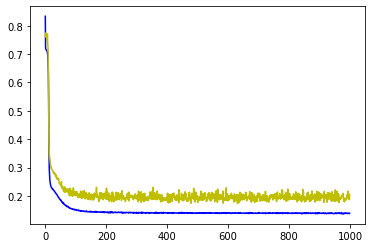

In [30]:
#Train this model, to predict temp after one month

model_next_month.apply(weight_reset)
training(1000, model_next_month, loss_fn, month_opt, month_train_dl, month_test_dl)

## Testing...get da bloody predictions

In [35]:

#Previous 7 days temperature (month, max_temp, min_temp,     month, max_temp, min_temp....7x times)
own_data = torch.from_numpy(np.array([10, 23.3, 16.2, 10, 22.1, 14.8, 10, 21.9, 14.7, 10, 19.7, 13.7, 10, 20.4, 13.6, 10, 17.2, 12.3, 10, 10, 9]))

#Normalizing the test data with the training set's MEAN and STD for every model
day_own_data = (own_data - day_means) / day_stds
week_own_data = (own_data - week_means) / week_stds
month_own_data = (own_data - month_means) / month_stds

#Prediction with every model
day_preds = model_next_day(day_own_data.float())
day_preds = (day_preds*day_stds)+day_means

week_preds = model_next_week(week_own_data.float())
week_preds = (week_preds*week_stds)+week_means

month_preds = model_next_month(month_own_data.float())
month_preds = (month_preds*month_stds)+month_means

#print('ORIGINAL_INPUT:')

#print(own_data)

print('PREDICTION in 1 day (2019.10.30):')
print("Max_temp:%.2f  Min_temp:%.2f "%(float(day_preds[1]),float(day_preds[2])))
print("AVG. TEMP:%.2f C°"%((float(day_preds[1])+float(day_preds[2]))/2))
#print(day_preds)
print(" ")

print('PREDICTION in 1 week (2019.11.5):')
print("Max_temp:%.2f  Min_temp:%.2f "%(float(week_preds[1]),float(week_preds[2])))
print("AVG. TEMP:%.2f C°"%((float(week_preds[1])+float(week_preds[2]))/2))
#print(week_preds)
print(" ")

print('PREDICTION in 1 month (2019.11.26):')
print("Max_temp:%.2f  Min_temp:%.2f "%(float(month_preds[1]),float(month_preds[2])))
print("AVG. TEMP:%.2f C°"%((float(month_preds[1])+float(month_preds[2]))/2))
#print(month_preds)



PREDICTION in 1 day (2019.10.30):
Max_temp:13.72  Min_temp:6.51 
AVG. TEMP:10.11 C°
 
PREDICTION in 1 week (2019.11.5):
Max_temp:17.26  Min_temp:8.89 
AVG. TEMP:13.07 C°
 
PREDICTION in 1 month (2019.11.26):
Max_temp:13.53  Min_temp:6.59 
AVG. TEMP:10.06 C°
